### DATA620 - Final Project
#### Michael Ippolito
7/7/2022

### Project Overview

It is common knowledge that many world languages are related to each other, with some borrowing words from others. For this project, I investigated similar words across various world languages, with the end goal being two-fold. First, I'll demonstrate how NLP and graph analytics can be used to evaluate which languages are most similar to each other. And second, I'll specificially focus on evaluating quantitatively which languages are most similar to several common languages. This isn't intended to be a comprehensive etymological study, but instead an application of both NLP and network graphs to perform a specific, limited analysis.

Since the corpus of world languages is vast, I limited the texts I evaluated to a small subset of languages, specifically twenty-two which are spoken in Europe and which can be expressed using the Latin-1 character set. Further, I limited the text from each language to two specific corpora. The first is a document translated across all languages I'll evaluate in the project, namely the Universal Declaration of Human Rights (https://www.un.org/en/about-us/universal-declaration-of-human-rights). The UDHR comes packaged into the NLTK and is translated into 335 languages with various encodings. The second set is a corpus of words translated using an online API called Yandex Translate. The words in the corpus are derived from a list of commonly used affixes and are used in this project to aid in comparing languages. The overal corpus consists of approximately 14,000 unique words, many of which are shared among multiple languages.


#### Limitations

One severe limitation is that, without a full understanding of each language, some words may be marked as equivalent between two languages, when they actually have vastly different meanings. For example, the word "be" in Romansch doesn't mean the same thing as the English word "be"; it actually means "just," "only," or "exclusively." But for the purposes of this project, I won't have a comprehensive way to make that distinction.

An additional concern, as shown in the bipartite projection graph that follows, is that each language appears to be related to every single other language. This indicates that some of the centrality metrics won't be useful. But I'll add in weights (e.g. number of words in common) to further evaluate how each language relates to the others.

In addition, we're only comparing languages to each other by individual unigrams. We're ignoring any similarities in pronunciation, syntax, etc.

We'll also ignore stemming or lemmatization, as we want to limit our study to the character level, without knowing much of anything about the different syntaxes, spellings, grammar, or pronunciation of the languages.

And finally, our corpus will be small. This means that we can't necessarily extrapolate our resuls to a more general comparison among world languages.


#### Link to video presentation

[Video](https://github.com/mmippolito/cuny_data620_final_project/blob/main/ippolito_video.mp4?raw=true)

#### Python libraries

I'll use pandas for dataframe operations, NLTK for natural language processing, and networkx for graph analysis. The rest are standard fare for python programs.


In [1]:
# Load libraries
import matplotlib.pyplot as plt
import matplotlib.patches
import csv
import os
import numpy as np
from scipy import stats
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.io as pio
import nltk
import math
import collections
import time
import re
import requests
from nltk.corpus import udhr
import networkx as nx
import networkx.algorithms.bipartite as bipartite
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Set module options
pio.renderers.default = 'jupyterlab'       # Set ploty renderer so graphs show up in HTML output
pd.set_option('display.width', 160)        # Set pandas display options
pd.set_option('display.max_colwidth', 80)  # Set max width of each column


### Preparatory Work

#### Language selection

Here I define which languages I'll be evaluating. I'll limit the scope to several languages commonly spoken throughout Europe, as well as those that can be expressed in written format using the Latin-1 character set. This will present a large enough dataset to be useful, but one that can be compared across languages.


In [2]:
# Choose several languages spoken in Europe, whose written alphabet can be expressed using the latin-1 character set;
# keyed on language, value is the UDHR filename
languages = {
    'Basque': 'Basque_Euskara',
    'Danish': 'Danish_Dansk',
    'Dutch': 'Dutch_Nederlands',
    'Catalan': 'Catalan_Catala',
    'English': 'English',
    'Estonian': 'Estonian_Eesti',
    'Finnish': 'Finnish_Suomi',
    'French': 'French_Francais',
    'German': 'German_Deutsch',
    'Hungarian': 'Hungarian_Magyar',
    'Icelandic': 'Icelandic_Yslenska',
    'Irish': 'IrishGaelic_Gaeilge',
    'Italian': 'Italian_Italiano',
    'Latin': 'Latin_Latina',
    'Latvian': 'Latvian',
    'Luxembourgish': 'Luxembourgish_Letzebuergeusch',    # Note that Yandex calls this simply "Luxembourg"
    'Norwegian': 'Norwegian_Norsk-Bokmal',
    'Portuguese': 'Portuguese_Portugues',
    #'Romani': 'Romani',   # removed due to no support in Yandex API
    #'Romansch': 'Rhaeto-Romance_Rumantsch',   # removed due to no support in Yandex API
    'Scottish': 'ScottishGaelic_GaidhligAlbanach',
    'Spanish': 'Spanish_Espanol',
    'Swedish': 'Swedish_Svenska',
    'Welsh': 'Welsh_Cymraeg'
}


#### Word normalization strategy

First, I'll devise a word normalization strategy. This will be necessary to try correlating between words which are essentially the same across multiple languages, but whose spelling is slightly different. For example, the following words should be treated as equivalent:

| Language | Word |
| -------- | ---- |
| English | operation |
| Spanish | operación |
| French | opération |
| Portuguese | operação |
| Latin | operatio |

Note the accent over the "o" in Spanish, over the "e" in French, and over the "a" in Portuguese. Likewise, the "ção" in the Portuguese word can be converted to "tion." These should all be normalized to the stem "operat." To start with, I'll only convert to lowercase; in subsequent runs I'll do more normalization to see how that affects similarity metrics.


In [3]:
# Preliminary function to normalize word; I expect to add more to this later, e.g. lemmatizing and replacing extended characters with English equivalents
def normalizeWord(word, lang=''):
    r = word.lower()
    return r


#### Yandex Translate API

In order to explore similarities among languages, we'll make use of a (relatively) free online translation API from Yandex (https://translate.yandex.com/). Noting that many languages have affixes that mean the same thing in English but have a slightly different spelling, I'll investigate whether normalizing across affixes will strengthen the relationship between certain languages. Affixes come in three forms: prefixes (at the beginning of a word), infixes (in the middle of a word), or suffixes (at the end of a word). For example, the following illustrates how the English suffix "sion" in the word "depression" translates across various languages:

Language | Trnaslation | suffix
-------- | ----------- | ------
Basque | depresioa | sioa
Catalan | depressió | ssió
Danish | depression | ssion
Dutch | depressie | ssie
Estonian | depressioon | ssioon
French | dépression | ssion
German | depression | ssion
Hungarian | depresszió | sszió
Italian | depressione | ssione
Latvian | depresija | sija
Luxembourg | depressiounen | ssiounen
Norwegian | depresjon | sjon
Portuguese | depressao | ssao
Spanish | depresión | sión
Swedish | depression | ssion

Normalizing the suffix on each word would all translate to the same English word: "depression." To that end, I've developed a list of about 150 affixes that we're interested in trying to normalize. We'll load the affixes from a csv I adapted from yourdictionary.com.

To satisfy Yandex's EULA, the follow applies to all words translated in this document:

Translated by Yandex.Translate \
http://translate.yandex.com/


#### Affix list

Now we'll load the list of affixes that we'll be examinging.


In [80]:
# Read list of affixes; sources:
# https://examples.yourdictionary.com/reference/examples/prefix-examples.html (prefixes)
# https://examples.yourdictionary.com/list-of-suffixes-and-suffix-examples.html (suffixes)
#
# affixes.csv fields:
#     type: prefix, infix, suffix
#     affix
#     definition
#     examples
#     status: todo or done, indicating whether we've already looked this word up

# Open and read the affix file
fh = open('affixes.csv', 'r')
affixes = []
rdr = csv.reader(fh)
for row in rdr:
    # Append the affix to the list
    affixes.append({'type': row[0], 'affix': row[1], 'definition': row[2], 'examples': row[3], 'status': row[4]})
fh.close()

# Convert to dataframe for a prettier display
dfaffix = pd.DataFrame(affixes)
display(dfaffix.head(15).style.hide(axis=0))


#### Translate words

We'll use the Yandex API to translate each of the example words above into each language we're interested in. Then we'll investigate how (or if) they should be normalized.


In [5]:
# Read Yandex API key
fh = open('.apikey_yandex', 'r')
apikey = fh.read()
fh.close()
urlbase = 'https://translate.yandex.net/api/v1.5/tr.json/translate?key={}'.format(apikey)

# Yandex API query string parameters:
# ? [key=<API key>]
# & [text=<text to translate>]
# & [lang=<translation direction>]
# & [format=<text format>]
# & [options=<translation options>]
# & [callback=<callback function name>]

# Read list of Yandex supported languages;
# source: https://yandex.com/dev/translate/doc/dg/concepts/api-overview.html
yandex_langs = {}
fh = open('yandex_langs.csv', 'r')
rdr = csv.reader(fh)
for row in rdr:
    # Each row will contain a language supported by Yandex and the language code, e.g.:
    # Azerbaijani,az
    yandex_langs[row[0]] = row[1]
fh.close()

# See if the translation file already exists on disk
forceLookup = False    # set to True to force the script to look up definitions even if the file exists
if os.path.exists('translated.csv') and forceLookup == False:
    
    # File already exists on disk; skip querying Yandex server
    print('file already exists on disk; skip querying Yandex server')

else:
    
    # File doesn't exist on disk, so load from Yandex server

    # Initialize list to store results
    trans = []

    # Iterate through list of affixes
    ct = 0
    for affix in affixes:
        if affix['status'] == 'done':
            continue
        print(affix['affix'])
        for lang in languages:
            yandex_lang = lang
            if lang == 'Luxembourgish': yandex_lang = 'Luxembourg'    # Yandex shortened Luxembourgish to Luxembourg
            if yandex_lang in yandex_langs.keys():
                print('\t' + lang)
                words = affix['examples'].split(',')
                for word in words:
                    word = word.strip()
                    print('\t\t' + word)
                    if lang == 'English':    # don't translate English to English; just add the row
                        row = {
                            'type': affix['type'],
                            'affix': affix['affix'],
                            'lang': lang,
                            'word': word,
                            'trans': word
                        }
                        trans.append(row)
                        ct += 1
                    else:
                        url = urlbase + '&lang=en-' + yandex_langs[yandex_lang] + '&text=' + word
                        r = requests.get(url)
                        if r.status_code == 200:
                            try:
                                j = json.loads(r.text)
                                if 'text' in j.keys():
                                    if len(j['text']) > 0:
                                        row = {
                                            'type': affix['type'],
                                            'affix': affix['affix'],
                                            'lang': lang,
                                            'word': word,
                                            'trans': j['text'][0].strip()
                                        }
                                        print('\t\t\t', row)
                                        trans.append(row)
                                        ct += 1
                                    else:
                                        print('no translation')
                            except Exception as ex:
                                print('err converting to json: ' + r.text + '; ' + str(ex))
                        else:
                            print('err: ' + r.text)
            else:
                print('\tlanguage not supported by Yandex:', lang)
    print('translations made:', ct)

    # Save to csv
    doWriteHeader = False
    if not os.path.exists('translated.csv'): doWriteHeader = True
    fh = open('translated.csv', 'a', newline='', encoding='latin-1')
    dw = csv.DictWriter(fh, trans[0].keys())
    if doWriteHeader: dw.writeheader()
    errct = 0
    for e in trans:
        try:
            dw.writerow(e)
        except Exception as ex:
            e2 = str(e)
            try:
                e2 = e2.encode("iso-8859-1")
                j = loads(e2)
                dw.writerow(j)
            except Exception as ex2:
                errct += 1
    print(errct, 'errors writing to csv')
    fh.close()


file already exists on disk; skip querying Yandex server


#### Load the corpora

Now we'll load the UDHR from the files provided by the NLTK, followed by the words translated using the Yandex API.


In [6]:
# Define function to load and tokenize words;
# first, load the words from the UDHR, then load the words from the Yandex dictionary
def tokenizeWords(normalizeFunc):
    # normalizeFunc: the normalize function to use
    # returns: dict of tokenized words keyed on language

    # Initialize a dict keyed on language, containing a list of individual tokens found in the UDHR for that language
    w = {}

    # UDHR

    # Iterate through the languages, reading each one from the NLTK's UDHR dataset
    for lang, filename in languages.items():
        
        # Initialize a set of words for this language
        w[lang] = set([])
        
        # Read words from each file
        for word in udhr.words(filename + '-Latin1'):
            
            # Only choose alphabetic words, including extended characters from the latin-1 character set
            if re.match(r'^[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff]+$', word):
                
                # Add the word to the set
                w[lang].add(normalizeFunc(word, lang))

    # Yandex
    
    # Make sure file exists
    if os.path.exists('translated.csv'):
    
        # Initialize array to store translated words
        trans = []
    
        # Load csv from disk
        fh = open('translated.csv', 'r', encoding='latin-1')
        rdr = csv.reader(fh)  # initialize reader
        header = []    # header row
        header = next(rdr)   # populate header
        ct = 0
        
        # Iterate through lines in csv file
        for row in rdr:
            d = {}    # Initialize dictionary
            ct += 1    # Increment counter
            
            # Load the row into a dictionary
            for i, e in enumerate(row):
                d[header[i]] = e
            
            # Make sure the translated word is in the dict that we're reading from
            if 'trans' in d.keys():
                
                # Only choose alphabetic words, including extended characters from the latin-1 character set
                if re.match(r'^[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff]+$', d['trans']):

                    # Add the word to the set
                    w[d['lang']].add(normalizeFunc(d['trans'], d['lang']))

    # Return the dict
    return w


### Round 1: Case Normalization

Run all the words through the normalizing function. This first pass will only make all the words lowercase. On subsequent passes, we'll do further normalization, including normlizing by affix.

In [7]:
# Tokenize the words using the preliminary normalize function
w = tokenizeWords(normalizeWord)

# Get total word count
totalWords = sum([len(w[lang]) for lang in w.keys()])
print('Total word count: ' + str(totalWords))

Total word count: 20932


#### Build network graph

Continuing EDA, the network graph is built. Each node is either a language or a word. A language connects to a word (and vice versa) in an undirected fashion.


In [8]:
# Function to generate network graph from tokenized words
def genGraph(w, show_progress):
    # w: dictionary of tokenized words keyed on language

    # Create new blank networkx graph
    g = nx.Graph()

    # Iterate through each language
    for lang in w.keys():
        g.add_node(lang, bipartite=0)    # add the language as a top node
        ct = 0    # counter of words in this language
        for word in w[lang]:
            ct += 1
            g.add_node(word, bipartite=1)    # add the word as a bottom node
            g.add_edge(lang, word)               # connect the language to the word as an edge
        if show_progress == True:
            print(lang + ': ' + str(ct) + ' words')
    
    # Return the network graph
    return g

# Generate the network graph
g = genGraph(w, True)

Basque: 1015 words
Danish: 942 words
Dutch: 876 words
Catalan: 904 words
English: 895 words
Estonian: 1048 words
Finnish: 1070 words
French: 914 words
German: 947 words
Hungarian: 967 words
Icelandic: 1055 words
Irish: 947 words
Italian: 936 words
Latin: 1098 words
Latvian: 834 words
Luxembourgish: 954 words
Norwegian: 951 words
Portuguese: 951 words
Scottish: 844 words
Spanish: 885 words
Swedish: 965 words
Welsh: 934 words


#### Network graph diagram

Draw a preliminary network graph with all nodes (languages and words). There won't be a lot of information to be gained from this initially.


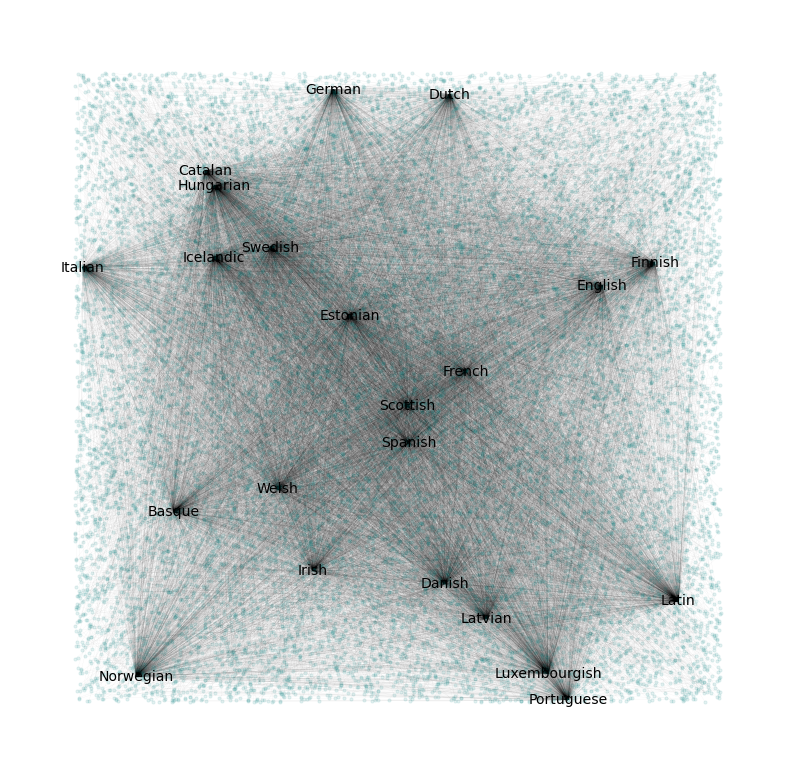

In [9]:
# Generate labels for language names
labels = {}
for lang in w.keys():
    labels[lang] = lang

# Draw networkx graph
options = {
    'node_color': 'teal',
    'node_size': 10,
    'width': .15,
    'alpha': 0.1
}
plt.figure(1, figsize=(14,14))
pos = nx.random_layout(g, center=None, dim=2, seed=777)
nx.draw_networkx_labels(g, pos=pos, labels=labels, font_size=14, font_color='black')
nx.draw(g, pos=pos, **options)
plt.show()


#### Count words common between language pairs

Using networkx's common_neighbors function, calculate the number of words that are common between each language pair.


In [74]:
# Function to generate dataframe of weights
def genWeights(w, g, include, pct=False):
    # w: the list of languages and tokenized words
    # g: graph object
    # include: which languages to include as columns
    # pct: return a dataframe with the weights in percentage of words rather than word counts
    # returns: dataframe of overlapping word counts (or percentage of words) between each pair of languages
    
    # If include is a blank list, then include all columns
    if len(include) == 0: include = list(w)

    # Create blank dataframes
    dfwt = pd.DataFrame(columns=['lang'] + include)
    dfwtpct = pd.DataFrame(columns=['lang'] + include)
    
    # Iterate through each language (outer loop)
    for lang1 in sorted(w.keys()):
        row = {'lang': [lang1]}    # set the starting language
        rowpct = {'lang': [lang1]}    # set the starting language
        
        # Iterate through each language (inner loop)
        for lang2 in sorted(w.keys()):
            if lang2 not in include: continue
            num_in_common = 0
            if lang1 != lang2:    # don't count if this is the same as the starting language
                cn = nx.common_neighbors(g, lang1, lang2)    # use network graph common neighbors to find the number of common words
                num_in_common = (sum(1 for _ in cn))
            row[lang2] = [num_in_common]
            
            # Calculate the percentage in common
            rowpct[lang2] = [num_in_common / (g.degree[lang1] + g.degree[lang2])]
            
        # Add the new row to the dataframe
        dfwt = pd.concat([dfwt, pd.DataFrame.from_dict(row, orient='columns')], ignore_index=True)
        dfwtpct = pd.concat([dfwtpct, pd.DataFrame.from_dict(rowpct, orient='columns')], ignore_index=True)

    # Sort the columns alphabetically, with the lang column first
    cols = sorted(dfwt.columns)
    cols.remove('lang')
    cols = ['lang'] + cols
    dfwt = dfwt.reindex(cols, axis=1)
    dfwtpct = dfwtpct.reindex(cols, axis=1)

    # Return the dataframe
    if pct == True:
        return dfwtpct
    else:
        return dfwt

# Print dataframe
print('Overlapping words in each language pair')
display(genWeights(w, g, [], pct=False).style.hide(axis=0))

Overlapping words in each language pair


#### Explore overlapping words

Now that the corpora have been tokenized, we'll look at which words overlap in other languages. We'll do this naively at first, recognizing that more normalization will be required. But this will give us a first look. First, define a function to convert the word lists keyed on language into a dataframe.


In [11]:
# Function to create a dataframe from the tokenized words
def tokenizedWordsToDf(w):
    # w is the dict keyed on languages containing the list of tokenized words
    # returns a dataframe containting languages and words

    # Create new dict to store languages and words, which we'll convert to a dataframe
    newdict = {'lang': [], 'word': []}

    # Iterate through the languages in the tokenized word dict
    for lang in w.keys():
        
        # Iterate through each word in this language
        for word in w[lang]:
            newdict['lang'].append(lang)    # append the language to the dict of lists
            newdict['word'].append(word)    # append the word to the dict of lists

    # Convert the dict to a dataframe
    df = pd.DataFrame.from_dict(newdict)
    return df


Next, define a function to find overlapping words. We'll do this by using NetworkX's common_neighbors function to compare each language with all the others. The function will return a dataframe that contains the counts of words that overlap at least one other word in each language.


In [12]:
# Function to find overlapping words
def findOverlapping(g):
    # g: the network graph to traverse
    # returns a dataframe containing the counts of words that overlap at least one other word in each language

    # Create a dataframe to show which words overlap other languages
    dfoverlap = pd.DataFrame(columns=['lang', 'unique_words', 'overlapping_words'])

    # Iterate through the languages in the tokenized word dict
    nodes = [node[0] for node in g.nodes(data=True) if node[1]['bipartite'] == 0]
    for lang1 in sorted(nodes):
        
        # Iterate through each language (inner loop)
        overlappingWords = set([])
        for lang2 in sorted(nodes):
            if lang1 != lang2:    # don't count if this is the same as the starting language
                cn = nx.common_neighbors(g, lang1, lang2)    # use network graph common neighbors to find the number of common words
                for word in cn:
                    overlappingWords.add(word)

        # Add the entry to the overlap dataframe
        row = {'lang': [lang1], 'unique_words': [g.degree[lang1]], 'overlapping_words': [len(overlappingWords)]}
        dfoverlap = pd.concat([dfoverlap, pd.DataFrame.from_dict(row)])

    # Return the dataframe after sorting by column name
    dfoverlap = dfoverlap.reindex(sorted(dfoverlap.columns), axis=1)
    return dfoverlap


Now that the functions are defined, we'll convert the dictionary of tokenized words to a dataframe and count the occurence of overlapping words among all languages.


Main dataframe containing languages and words:



Overlapping words (in descending order of overlapping word count):


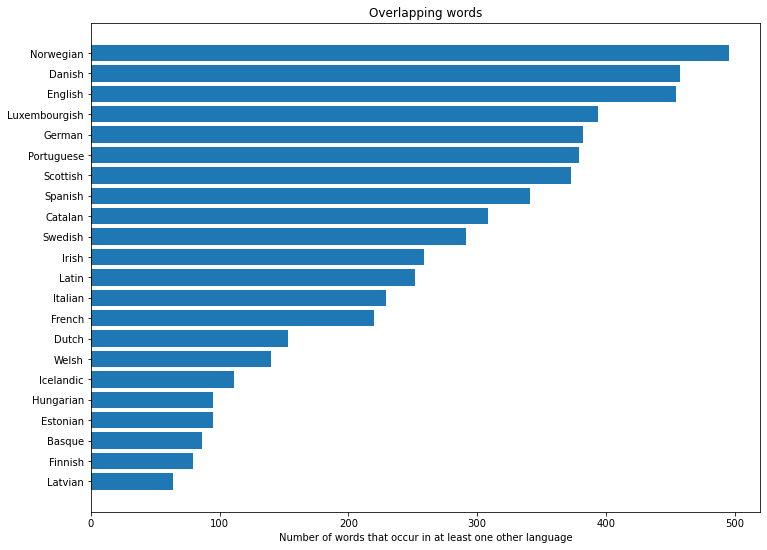

In [13]:
# Convert tokenzied word dict to dataframe
df1 = tokenizedWordsToDf(w)
print('Main dataframe containing languages and words:')
display(df1.head(15).style.hide(axis=0))
print()

# Find overlapping word counts
dfoverlap = findOverlapping(g)

# Display overlapping word counts
dfoverlap.sort_values(['overlapping_words'], inplace=True, ascending=False)
print('Overlapping words (in descending order of overlapping word count):')
display(dfoverlap.style.hide(axis=0))
print()

# Overlapping words bar chart
dfoverlap.sort_values(['overlapping_words'], inplace=True, ascending=True)
plt.figure(1, figsize=(12, 9))
plt.barh(y=dfoverlap['lang'], width=dfoverlap['overlapping_words'])
plt.title('Overlapping words')
plt.xlabel('Number of words that occur in at least one other language')
plt.show()


#### Preliminary projection

Perform a bipartite projection of languages onto the main graph. This will help in assessing which languages are related to each other.


In [14]:
# Function to perform bipartite projection of languages onto main graph
def projectNodes(g, side):
    # g: networkx graph
    # side: langs or words
    # returns: projected graph

    # Assign top and bottom nodes (languages and words, respectively)
    langs = [n[0] for n in g.nodes(data=True) if n[1]['bipartite'] == 0]
    words = [n[0] for n in g.nodes(data=True) if n[1]['bipartite'] == 1]

    # Project languages onto graph
    gp = None
    if side == 'langs':
        gp = bipartite.weighted_projected_graph(g, langs)
    else:
        gp = bipartite.weighted_projected_graph(g, words)

    # Return the projected graph
    return gp

# Project the graph
gp = projectNodes(g, side='langs')


#### Bipartite projection graph

Since this is a bipartite graph, to compare like nodes we'll need to project the nodes onto the main graph. In this case, we're comparing languages to languages, so we'll project languages onto the main graph. Since this is a complete graph, just looking at the projected graph won't give us any information. We'll need to trim the graph at various weights to make any kind of useful comparison.


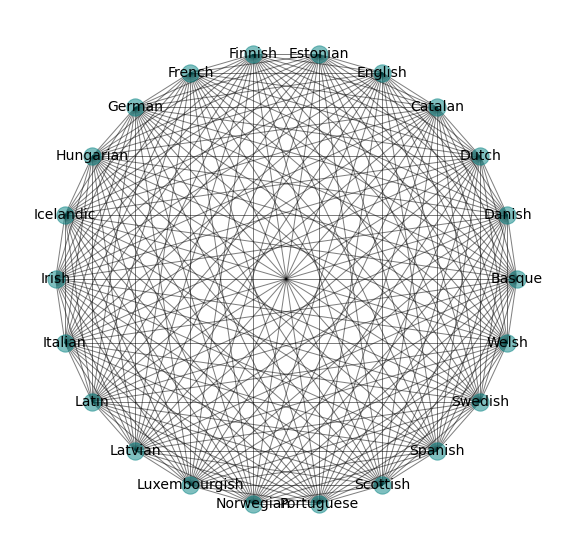

In [15]:
# Function to draw bipartite projection graph
def drawProjectedGraph(gp):
    # gp: projected graph
    # returns: none

    # Plot bipartite projection graph
    options = {
        'node_color': 'teal',
        'node_size': 300,
        'width': 1,
        'alpha': 0.5
    }
    plt.figure(1, figsize=(10, 10))
    labels = {}
    for node in gp.nodes():
        labels[node] = node
    pos = nx.circular_layout(gp)
    nx.draw_networkx_labels(gp, pos=pos, labels=labels, font_size=14, font_color='black')
    nx.draw(gp, pos=pos, **options)
    plt.show()

drawProjectedGraph(gp)


#### Function to trim edges

Since our initial bipartite projection shows that all nodes are connected to each other by at least one word, we'll need to set a limit on what to consider a "significant" relationship. We'll base this significance on the number of words in common between each language pair, which we already know is the weight of the graph edge. We'll need a function to trim the edges based on a specified weight.


In [16]:
# Define function to trim edges based on weight; modified from source:
# Maksim Tsvetovat & Alexander Kouznetsov, Social Network Analysis for Startups, 2011
def trim_edges(g, weight, add_all_nodes):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight or add_all_nodes == True:
            if f not in g2.nodes:
                g2.add_node(f, bipartite=g.nodes(data=True)[f]['bipartite'])
            if to not in g2.nodes:
                g2.add_node(to, bipartite=g.nodes(data=True)[to]['bipartite'])
        if edata['weight'] > weight:
            g2.add_edge(f, to, weight=edata['weight'])
    return g2


#### Trimmed projection graphs

Trim the projected graphs to various weights to investigate which languages are more closely related to each other.


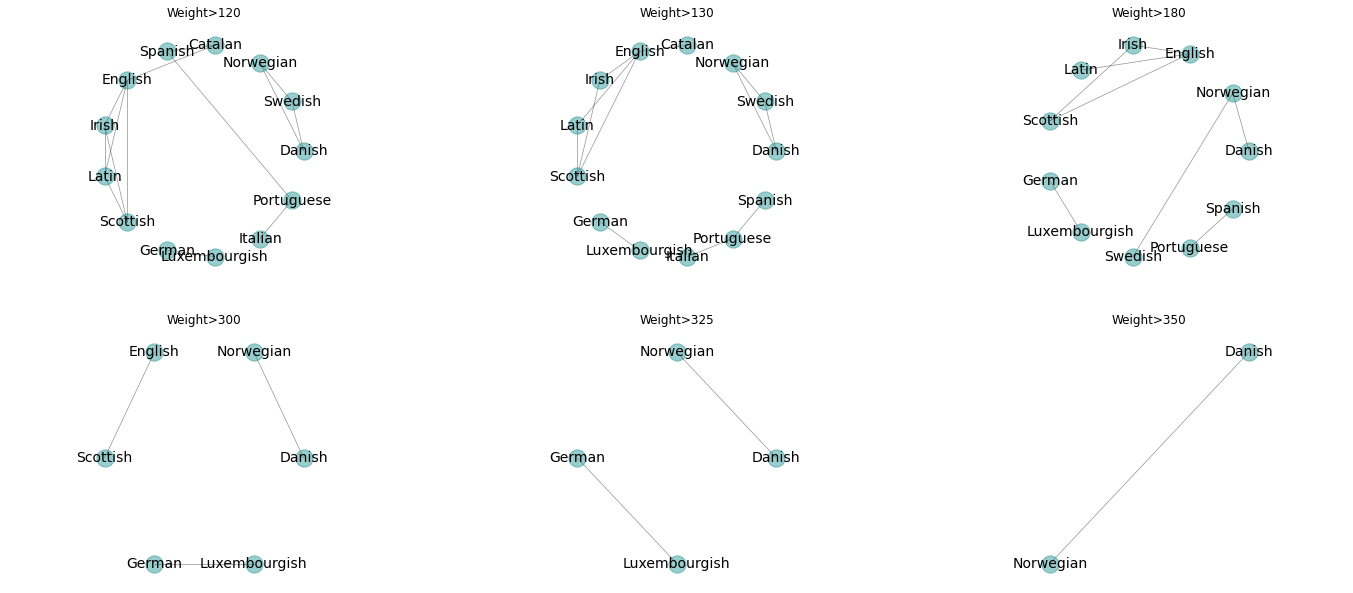

In [17]:
# Function to draw trimmed projection graphs
def drawTrimmedGraphs(gp, dim, rows_columns, weights):
    # gp: projected graph
    # dim: tuple for dimensions of graph (w, h)
    # weights: list of weights we want to show
    # rows_columns: strings indicating the number of rows and columns for the subgraphs (e.g. "33")
    # returns: none

    # Graph options
    options = {
        'node_color': 'teal',
        'node_size': 300,
        'width': .75,
        'alpha': 0.4
    }

    # Plot trimmed bipartite projection graph
    plt.figure(1, figsize=dim)

    # Iterate through the lsit of weights we want to graph
    for i, wt in enumerate(weights):

        # Create subplot
        plt.subplot(int(rows_columns + str(i + 1)))
        plt.title('Weight>' + str(wt))

        # Trim the projected graph to the specified weight
        trimmed_gp = trim_edges(gp, wt, False)

        # Generate label dict
        labels = {}
        for node in trimmed_gp.nodes():
            labels[node] = node

        # Draw circular graph
        pos = nx.circular_layout(trimmed_gp)
        nx.draw_networkx_labels(trimmed_gp, pos=pos, labels=labels, font_size=14, font_color='black')
        nx.draw(trimmed_gp, pos=pos, **options)
        plt.margins(x=0.4)

    # Render the plot
    plt.show()

# Define the weights we're interested in
weights = [120, 130, 180, 300, 325, 350]

# Draw the trimmed graphs
drawTrimmedGraphs(gp, (24, 16), '33', weights=weights)


#### Connected component subgraphs

As illustrated above, a number of connected component subgraphs are readily apparent. These form the clusters of languages that are most similar to each other.


Weight=120


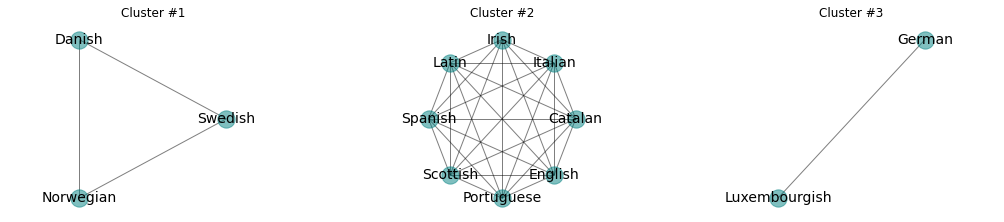


Weight=130


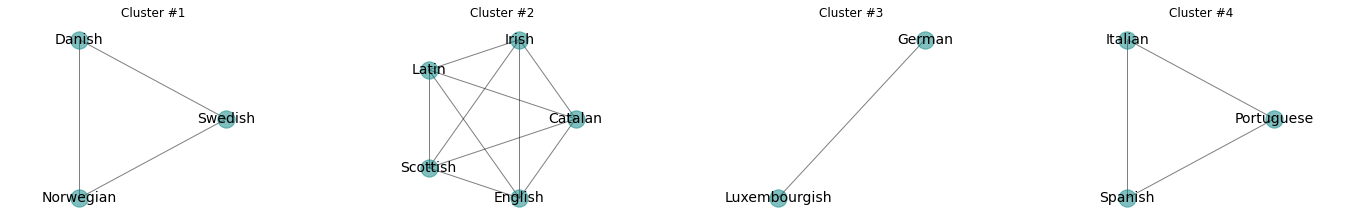


Weight=180


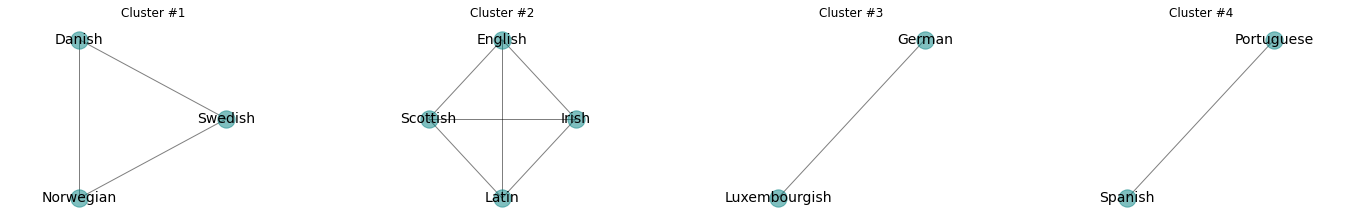


Weight=300


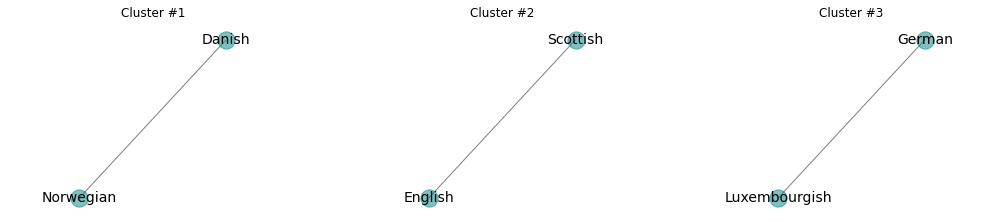


Weight=325


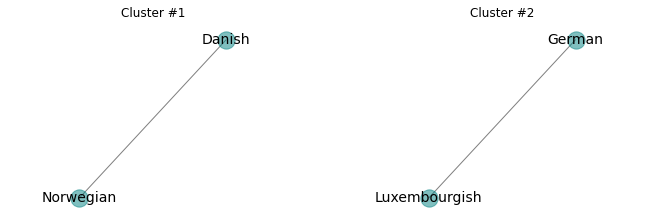


Weight=350


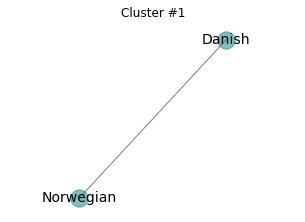

In [18]:
# Function to draw connected component subgraphs
def drawSubgraphs(gp, weights, titles=[]):

    # Set graph options
    options = {
        'node_color': 'teal',
        'node_size': 300,
        'width': 1,
        'alpha': 0.5
    }

    # Iterate through weights to trim the projected graph
    for wtnum, wt in enumerate(weights):

        # Init
        i = 0    # counter for plot #
        rows_columns = '34'    # grid size rows x columns
        print("Weight=" + str(wt))

        # Iterate through subgraphs
        plt.figure(1, figsize=(24, 12))
        for cc in nx.connected_components(trim_edges(gp, wt, False)):

            # Extract the subgraph
            sg = gp.subgraph(cc)
            i += 1

            # Generate label dict
            labels = {}
            for node in sg.nodes():
                labels[node] = node

            # Draw the component subgraph
            plt.subplot(int(rows_columns + str(i)))
            if len(titles) == 0:
                plt.title('Cluster #' + str(i))
            else:
                plt.title(titles[wtnum][i - 1])
            pos = nx.circular_layout(sg)
            nx.draw_networkx_labels(sg, pos=pos, labels=labels, font_size=14, font_color='black')
            nx.draw_circular(sg, **options)
            plt.margins(x=0.4)

        plt.show()
        print()

# Draw the subgraphs with generic cluster names
drawSubgraphs(gp, weights, [])


#### Regional language families - preliminary analysis

As shown, even with some minimmal normalization, there is quite a bit of overlap between certain languages. The subgraphs nicely illustrate that commonalities are readily apparent between languages spoken in regions that are geographically close to one another. In particular, the Scandianavian countries of Norway, Sweden, and Denmark are similar, as are three languages most commonly spoken in the UK (English, Irish, and Scottish). It is notable that Latin also makes an appearance in the same family, but Welsh does not, indicating the at some point the Welsh language diverged from the Latin roots that English, Irish, and Scottish still maintained. Not surprisingly, the two other clusters that exhibit strong ties are German and Luxembourgish, and Spanish and Portugues.


Weight=180


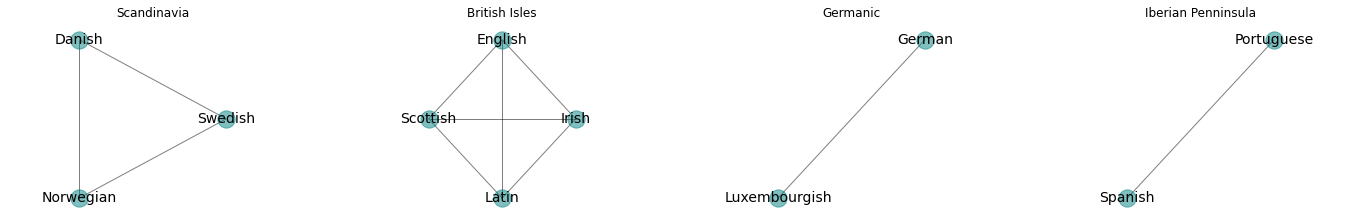

In [19]:
# Draw subgraphs illustrating regional language families
drawSubgraphs(gp, [180], [['Scandinavia', 'British Isles', 'Germanic', 'Iberian Penninsula']])


### Round 2: Normalize Characters

Beyond just normalizing to lowercase, I investigated other ways to normalize the corpus to make certain we weren't missing comparison opportunities. For this round, I looked at normalizing character sets and finding word similarities using machine learning. The approach at each step will be the same as above: Normalize, graph, analyze. To that end, since we'll be performing many of the same steps, I'll define some functions to perform these steps in a repeatable manner.


#### Repeatable function

We'll define a function to do the following:

1. convert the tokenized word lists to a dataframe
2. find overlapping words
3. display the counts


In [20]:
# Function to convert the tokenized word lists to a dataframe, find overlapping words, and display the counts
def regenDf(w_local, g_local, dfoverlap_old, iteration, displayDf):
    # w: the tokenized word list
    # dfoverlap_old: dataframe of overlapping words from a previous run
    # iteration: tells the function what label to put onto existing columns to differentiate it from subsequent runs
    # displayDf: do or don't display the table of overlapping word counts
    # returns: a dataframe of languages and words
    # displays: a table and bar chart of word counts

    # Generate dataframe from tokenized word list
    df = tokenizedWordsToDf(w_local)

    # Find overlapping words
    dfoverlap = findOverlapping(g_local)

    # Rename the words and overlap columns in the existing table to differentiate them from the new values
    dfoverlap_old.rename(columns={'unique_words': 'unique_words' + str(iteration), 'overlapping_words': 'overlapping_words' + str(iteration)}, inplace=True)
    
    # Merge the old dfoverlap from previous runs onto the new one
    dfoverlap = pd.merge(dfoverlap, dfoverlap_old, on=['lang'], how='outer')
    
    # Display overlapping word counts if specified
    if displayDf == True:
        print('Overlapping words:')
        dfoverlap.sort_values(['overlapping_words'], inplace=True, ascending=False)
        display(dfoverlap)
        print()

    # Overlapping words bar chart
    dfoverlap.sort_values(['overlapping_words'], inplace=True, ascending=True)
    plt.figure(1, figsize=(12, 9))
    plt.barh(y=dfoverlap['lang'], width=dfoverlap['overlapping_words'])
    plt.title('Overlapping words')
    plt.xlabel('Number of words that occur in at least one other language')
    plt.show()
    
    # Return the dataframe of generated from the tokenized word list
    return df, dfoverlap


#### Explore character sets

Since the languages I'm investigating contain characters beyond the usual twenty-six found in English, I explored what characters were used in the corpus to see if there were ways of normalizing them. Some examples:

| Character | Language(s) |
|-----------|--------------------------------|
| à | French |
| é | French |
| ñ | Spanish |
| ø | Danish, Norwegian |
| ß | German |


In [21]:
# Build a list of every letter used in all corpora
all_letters = [letter for lang in w.keys() for word in w[lang] for letter in word]

# Create a set of all unique letters
letters = set(all_letters)

# Count the number of letters across all corpora and store in a dataframe
letterct = [all_letters.count(letter) for letter in letters]
dfletters = pd.DataFrame.from_dict({'letter': list(letters), 'ct': letterct})
print('Letter counts across all corpora:')
display(dfletters.sort_values(['ct'], ascending=False).style.hide(axis=0))


Letter counts across all corpora:


#### ASCII equivalent characters

Many characters can be normalized to their approximate ASCII equivalents. For eample (building upon our previous list):

| Character | Language(s) | Approximate English equivalent |
|-----------|-------------|--------------------------------|
| à | French | a |
| é  | French | e |
| ñ | Spanish | n |
| ø | Danish, Norwegian | o |
| ß | German | ss |

The following loads a table of equivalents I manually created.


In [22]:
# Load table of approximate ASCII equivalent letters
dfnewletters = pd.read_csv('dfletters.csv', encoding='latin-1')


#### Digraphs and Trigraphs

As part of character normalization, we'll also look at digraphs and trigraphs, i.e. two- and three-letter combinations that make the same sound. For example:

| Digraph | Example | Sound |
| --- | --- | --- |
| ph | phone | f |
| pp | apple | p |
| ss | dessert | z |
| tch | watch | ch |
| wr | wrist | r |

Digraphs and trigraphs also occur in other languages:

| Language | Digraph | Example | Translation | Sound |
| --- | --- | --- | --- | --- |
| Spanish | ll | toalla | towel | y |
| French | pp | appartement | apartment | p |
| German | sch | Wunsch | wish | sh |

Although the Royal Spanish Academy officially removed digraphs as separate letters in the Spanish alphabet in 2010, digraphs still occur in Spanish words, as they do in other languages. It would be nice to normalize these down to a single letter such that they would more closely match their English translations. For example:

| Language | Digraph | Word | Normalized Word |
| --- | --- | --- | --- |
| English | ph | phone | fone |
| Spanish | ll | toalla | toala |
| French | pp | appartement | apartement |
| German | sch | Wunsch | Wunsh |

Combining digraph/trigraph normalization with normalizing by character set, we'll define a new normalization function.

Source: https://longmanhomeusa.com/blog/teaching-consonant-blends-digraphs-and-trigraphs/


#### Normalization function

Define a new normalization function which performs the character substitutions.


In [23]:
# Define which digraphs and trigraphs we'll be normalizing
digraphs = {
    'ck': 'k',
    'kn': 'n',
    'll': 'l',
    'nn': 'n',
    'ph': 'f',
    'pp': 'p',
    'sch': 'sh',
    'ss': 's',
    'tch': 'ch',
    'wh': 'w',
    'wr': 'r',
    'zz': 'z'
}

# Expanded normalization function, including substituting approximate ASCII equivalent characters
def normalizeWord2(word, lang=''):
    
    # Assign word to a temporary variable (necessary to prevent array boundary errors) and convert to lower case
    tmp = word.lower()
    
    # Initialize the new, normalized word
    r = ''
    
    # First pass to normalize characters
    for letter in tmp:
        repl = letter
        try:
            repl = dfnewletters[dfnewletters['letter'] == letter].iloc[0]['newletter']
        except:
            # This will usually mean that the letter isn't in the list, e.g. a hyphen;
            # in these cases, just use the original letter.
            pass
        r += repl    # replace with approximate ASCII equivalent character
    
    # Second pass to normalize digraphs and trigraphs
    for digraph, repl in digraphs.items():
        r = r.replace(digraph, repl)
    
    return r


#### Normalize by character substitution

Re-normalize the corpora using the new function that substitutes approximate ASCII equivalent characters. Then regenerage the graph and examine the overlapping word counts.


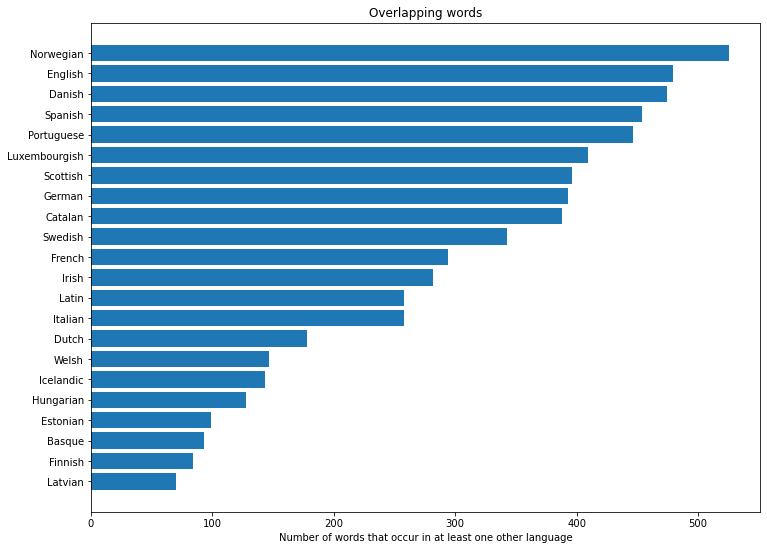

In [24]:
# Tokenize the words using the slightly more advanced normalize function that substitutes approximate English equivalent characters
w2 = tokenizeWords(normalizeWord2)

# Regenerate graph using the new tokenized words
g2 = genGraph(w2, False)

# Regenerate the dataframe, again looking at overlapping word counts
df2, dfoverlap2 = regenDf(w2, g2, dfoverlap, 1, False)


#### Compare to previous run

We'll want to compare how many more words overlap other languages after each round of normalization. We'l create a function to do that.


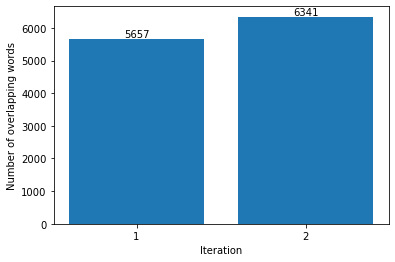

In [25]:
# Function to display bar chart of overlapping word counts for each iteration
def iterationSummary(dfoverlap, iteration):
    valueArr = ['overlapping_words']
    for i in range (1, iteration):
        valueArr.append('overlapping_words' + str(i))
    dfmelt = pd.melt(dfoverlap, id_vars=['lang'], value_vars=valueArr)
    for i in range(1, iteration):
        dfmelt.loc[dfmelt['variable'] == 'overlapping_words' + str(i), 'variable'] = str(i)
    dfmelt.loc[dfmelt['variable'] == 'overlapping_words', 'variable'] = str(iteration)
    dfmelt.rename(columns={'variable': 'iteration', 'value': 'overlapping_words'}, inplace=True)
    dfgrp = dfmelt.groupby(['iteration'], as_index=False).agg({'overlapping_words': 'sum'})
    fig, ax = plt.subplots()
    bars = ax.bar(dfgrp['iteration'], dfgrp['overlapping_words'])
    plt.xlabel('Iteration')
    plt.ylabel('Number of overlapping words')
    ax.bar_label(bars)
    plt.show()

# Display bar chart showing progress after each normalization step
iterationSummary(dfoverlap2, 2)


As shown, we gained about 700 words on this round. Now we can start comparing languages to each other.


#### Graph projections

As in the previous normalization round, to glean any useful information we'll need to project languages onto the main graph, then trim the resulting graph.


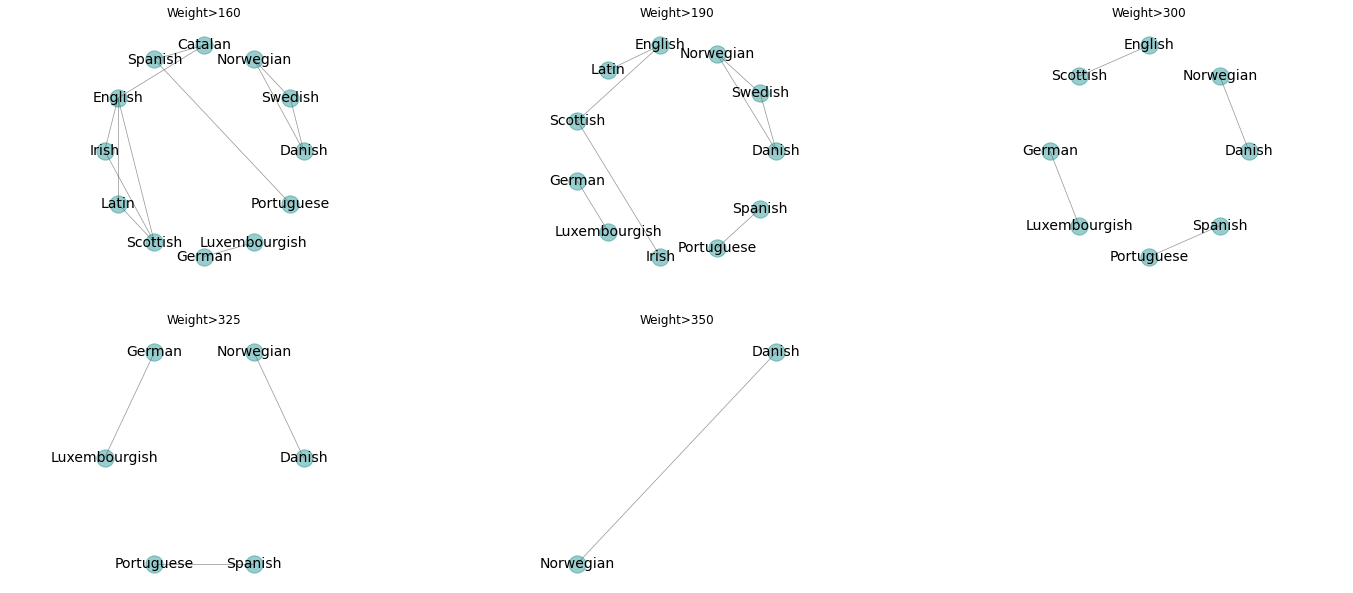

In [26]:
# Project languages onto main graph
gp2 = projectNodes(g2, side='langs')

# Draw projected graph
#drawProjectedGraph(gp2)

# Define the weights we're interested in
weights = [160, 190, 300, 325, 350]

# Draw trimmed graphs
drawTrimmedGraphs(gp2, (24, 16), '33', weights=weights)


#### Connected component subgraphs

We'll again look at subgraphs to more clearly illustrate how languages in the same geographic region are more similar to each other. These haven't changed much between the first and second rounds of normalization.


Weight=160


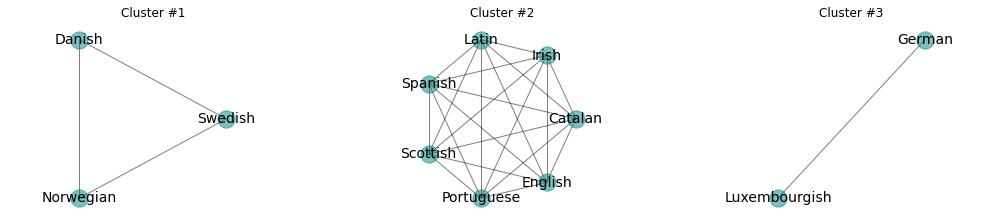


Weight=190


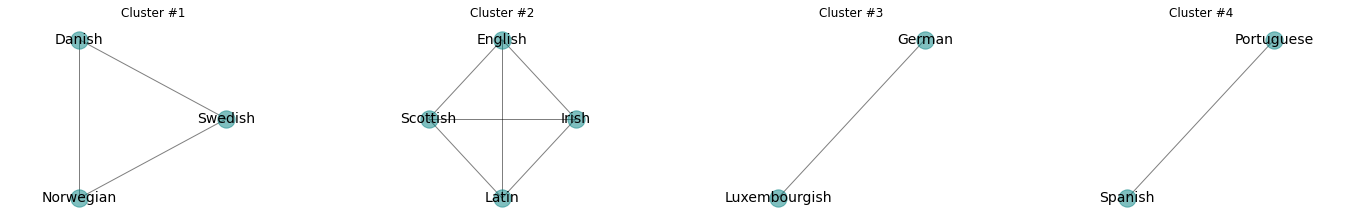


Weight=300


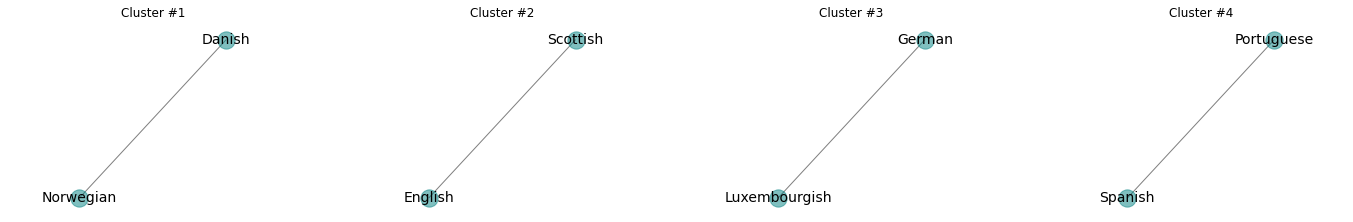


Weight=325


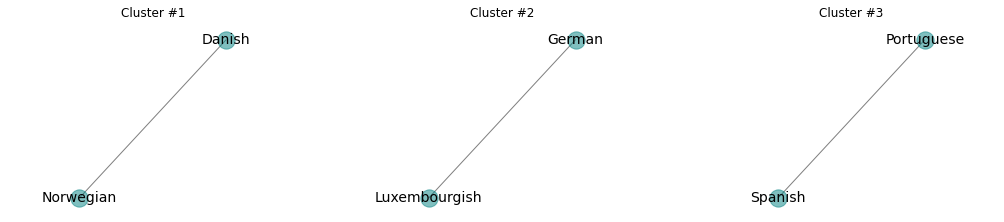


Weight=350


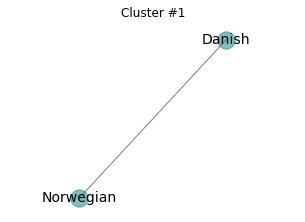

In [27]:
# Draw the subgraphs with generic cluster names
drawSubgraphs(gp2, weights, [])


### Round 3: Normalize by functional equivalency

We've performed two rounds of normalization, and we're starting to get a clear picture of which languages are related to each other. Now we'll take a closer look by investigating affixes used in various languages. The idea here is to examine how we can compare similar words across languages, such that we can assume that two words are similar enough that we can classify them as having come from the same origin and, therefore, can be called "functionally equivalent" for the purposes of our study. What we're looking for are things like the "tion" suffix in the word "operation":

| Language | Word |
| -------- | ---- |
| English | operation |
| Spanish | operación |
| French | opération |
| Portuguese | operação |
| Latin | operatio |


#### Read translated words

First, read in the file that contains the words we translated using the Yandex API. This file contains the affixes, the English word, and the translated word.


In [28]:
# Read the file containing translated words that use the various affixes we're interested in
dftrans = pd.read_csv('translated.csv', encoding='latin-1')
display(dftrans.head(15).style.hide(axis=0))


#### Examine prefixes

First, look at prefixes. For example, taking the prefix "extra," look at the word "extravert" across various languages.


In [29]:
# Look at prefix "extra" in "extravert"
display(dftrans[(dftrans['type'] == 'prefix') & (dftrans['word'] == 'extravert')].style.hide(axis=0))


Note that many in many languages, both the prefix "extra" and suffix "vert" are very similar to English. We want to say that these words are functionally equivalent to the English word.

| Language | Prefix | Suffix |
| -------- | ------ | ------ |
| English | extra | vert |
| Danish | ekstra | vert |
| Italian | estra | verso |
| Spanish | extro | vertido |

In other languages like Basque, the prefix may be similar, but the suffix is different. For these words, we won't call the word itself equivalent, but the prefix is so similat to English that we'd like to be able to normalize other words that contain the same prefix.

| Language | Prefix | Suffix |
| -------- | ------ | ------ |
| Basque | estra | dieratu |

So at this point we might use a normalization strategy such as:

| Language | Prefix | Normalized Prefix | Suffix | Normalized word |
| -------- | ------ | ------ | --------- | ------- |
| Basque | estra | extra | dieratu | extradieratu |
| Danish | ekstra | extra | vert | extravert |
| Italian | estra | extra | verso | extraverso |
| Spanish | extro | extra | vertido | extravertido |

As shown, that makes the Danish word "ekstravert" (normalized to "extravert") functionally equivalent to the English word "extravert." But the Italian and Spanish suffixes ("verso" and "vertido", respectively) are so similar to the English suffix ("vert") that we'd like to find a way to say these are also functionaly equivalent. What we want is a normalization strategy that results in something like:

| Language | Prefix | Normalized Prefix | Suffix | Normalized Suffix | Normalized Word | Equivalent to English? |
| -------- | ------ | ------ | --------- | ------- | -------| ----- |
| Basque | estra | extra | dieratu | dieratu | extradieratu | no |
| Danish | ekstra | extra | vert | vert | extravert | yes |
| Italian | estra | extra | verso | vert | extravert | yes |
| Spanish | extro | extra | vertido | vert | extravert | yes |


#### Suffixes

Before we try to refine our way of quantifying similarity, we'll first look at suffixes and see if we can apply the same principles we applied to prefixes.


In [81]:
# Examine suffix "eum" in "museum"
display(dftrans[(dftrans['type'] == 'suffix') & (dftrans['word'] == 'museum')].style.hide(axis=0))


We see that the English suffix "eum" is very similar in other languages.

| Language | suffix |
| -------- | ------ |
| English | eum |
| Basque | eoa |
| Catalan | eu |
| French | ée |
| Italian | eo |

Some have the same or similar suffix, but the prefix is slightly different:

| Language | prefix | suffix |
| -------- | ------ | ------ |
| Hungarian | Múz | eum |

Using the same strategy we used for prefixes, we're looking to develop a way to come up with something like:

| Language | Prefix | Normalized Prefix | Suffix | Normalized Suffix | Normalized Word | Equivalent to English? |
| -------- | ------ | ------ | --------- | ------- | -------| ----- |
| Basque | mus | mus | eoa | eum | museum | yes |
| Catalan | mus | mus | eu | eum | museum | yes |
| French | mus | mus | ée | eum | museum | yes |
| Hungarian | Múz | mus | eum | eum | museum | yes |
| Italian | Mus | mus | eo | eum | museum | yes |
| Welsh | amguedd | amguedd | fa | fa | amgueddfa | no |


#### Infixes

To round out our examination of affixes, let's look at infixes--i.e., word fragments that occur somewhere in the middle of a word.


In [31]:
# Look at the infix "dist" in "equidistant"
display(dftrans[(dftrans['type'] == 'infix') & (dftrans['word'] == 'equidistant')].style.hide(axis=0))


As with prefix and suffixes, similarities exist with infixes among languages. For example:

| Language | Word | Prefix | Infix | Suffix |
| ----| ---- | ---- | ---- | ---- |
| English | equidistant | equi | dist | ant |
| French | équidistants | équi | dist | ants |
| German | äquidistante | äqui | dist | ante |
| Swedish | ekvidistant | ekvi | dist | ant |


#### Levenshtein distance

At this point, we might write a function that splits a foreign word into its affixes (suffix, infix, and prefix), then returns some quantitative similarity between a reference affixes and the foregin affixes. For the moment (and more simply), we'll find the overall similiarity between the English word and the foreign word. Levenshtein distance seems like a good fit for both of these applications, so we'll define a function for it. This one is adapted from https://www.analyticsvidhya.com/blog/2021/02/a-simple-guide-to-metrics-for-calculating-string-similarity/.


In [32]:
# Function to calculate word similarity based on Levenshtein distance, adapted from:
# https://www.analyticsvidhya.com/blog/2021/02/a-simple-guide-to-metrics-for-calculating-string-similarity/
def LevenshteinDist(word1, word2):
    
    # Get word sizes
    size1 = len(word1) + 1
    size2 = len(word2) + 1
    
    # Create matrix
    m = np.zeros((size1, size2))
    
    # Fill first column with index of characters from the first word
    for i in range(0, size1):
        m[i, 0] = i

    # Fill first row with index of characters from the second word
    for j in range(0, size2):
        m[0, j] = j

    for i in range(1, size1):
        
        for j in range(1, size2):
            
            # See if the characters are the same at this position
            if word1[i - 1] == word2[j - 1]:
                
                # Set the matrix at this position to the minimum of:
                #    1) the value in the previous row and column
                #    2) the value in this column and the previous row, plus one
                #    3) the value in this row and the previous column, plus one
                m[i, j] = min(m[i - 1, j - 1], m[i - 1, j] + 1, m[i, j - 1] + 1)
            
            # if the characters are not the same at this position
            else:
                
                # Set the matrix at this position to the minimum of:
                #    1) the value in the previous row and column, plus one
                #    2) the value in this column and the previous row, plus one
                #    3) the value in this row and the previous column, plus one
                m[i, j] = min(m[i - 1, j - 1] + 1, m[i - 1, j] + 1, m[i, j - 1] + 1)
    
    # The Levenshtein distance will be given by the value in the matrix at the last row and column;
    # use this distance divided by the size of the first word to get the percentage difference,
    # then subtract this difference from 1 to get the percentage similarity
    return m[i, j]


Some examples of Levenshtein distance using the English prefix "extra":

| Language | Prefix | Levenshtein Distance |
|---- | ---- | ---- |
| Basque | estra | 1 |
| Catalan | extra | 0 |
| Danish | ekstra | 2 |
| Spanish | extro | 1 |


#### Distance threshold

Now that we have a function defined to calculate Levenshtein distance, we'll try the easy approach of simply calculating the Lenvenshtein distances between each pairs of words (reference word and foreign translation). If the Levenshtein distance falls below a certain threshold we'll call it functionally equivalent, in which case we'll change the normalized word to be an exact copy of the reference word.

But where do we set the threshold? In the example of the suffix "eum," we want all of the following to be functionally equivalent:

| English | language | Translation | Levenshtein Distance |
| ------- | -------- | ----------- | ------- |
| coliseum | Catalan | coliseum | 0 |
| mausoleum | Catalan | mausoleu | 1 |
| museum | Catalan | museu | 1 |
| coliseum | Italian | colisseo | 3 |
| mausoleum | Italian | mausoleo | 2 |
| museum | Italian | museo | 2 |
| coliseum | Latvian | coliseum | 0 |
| mausoleum | Latvian | mauzolejs | 2 |
| museum | Latvian | muzejs | 3 |

We could say that 3 is the threshold. But then what about things like this?

| English | Fake Word | Levenshtein Distance |
| --- | --- | --- |
| eum | east | 3 |
| eum | bla | 3 |
| eum | quz | 2 |

We don't want any of those to match. The best thing would be to create a simple ML model to decide the optimal threshold.


#### Normalize by character substitution

We'll need to do some prep work on the data before we can feed it into a model. Since the translated words will have extended Latin-1 characters, normalize them to their ASCII equivalents. We'll also normalize digraphs and trigraphs at the same time.


In [33]:
# Normalize letters to their English equivalents
dftrans['trans2'] = dftrans['trans'].apply(normalizeWord2)


#### Reference words

We've already said that this round of normalization will use Levenshtein distance to decide if two words are functionally equivalent. But equivalent to what? Should we compare French words to Spanish words? Spanish to English? Welsh to Latvian? Obviously, this requires some sort of reference list. We'll use English for convenience. But we'll have to use the normalized version of each English word. For example, instead of "megaphone," we'd want to use "megafone." This next block of code creates the list of reference words.


In [34]:
# Since we're using English as the reference language, filter on just English words
dfeng = dftrans[dftrans['lang'] == 'English']

# Select only the two columns we're interested in: the unmodified word and the normalized "translation";
# in this case, the word isn't really translated, since it's in English; but it *is* normalized using
# character and digraph/trigraph substitution
dfeng = dfeng[['word','trans2']]

# Rename the "translated" (i.e., normalized) word to be the reference word
dfeng = dfeng.rename(columns={'trans2': 'ref'})

# Remove the reference column if it already exists
dftrans = dftrans.drop(columns=['ref'], errors='ignore')

# Merge it onto the dataframe containing the words from all languages
dftrans = pd.merge(dftrans, dfeng, on=['word'], how='left')

# Display an example word
display(dftrans[dftrans['word'] == 'megaphone'])


type affix           lang       word      trans    trans2       ref
3556  prefix  mega         Basque  megaphone  megaphone  megafone  megafone
3559  prefix  mega        Catalan  megaphone    megàfon   megafon  megafone
3562  prefix  mega         Danish  megaphone    MEGAFON   megafon  megafone
3565  prefix  mega          Dutch  megaphone   megafoon  megafoon  megafone
3568  prefix  mega        English  megaphone  megaphone  megafone  megafone
3571  prefix  mega       Estonian  megaphone     ruupor    ruupor  megafone
3574  prefix  mega        Finnish  megaphone   megafoni  megafoni  megafone
3577  prefix  mega         French  megaphone  mégaphone  megafone  megafone
3580  prefix  mega         German  megaphone  megaphone  megafone  megafone
3583  prefix  mega      Hungarian  megaphone    Megafon   megafon  megafone
3586  prefix  mega      Icelandic  megaphone  megaphone  megafone  megafone
3589  prefix  mega          Irish  megaphone  megaphone  megafone  megafone
3592  prefix  mega        Italian  megaphone   megafono  megafono  megafone
3595  prefix  mega          Latin  megaphone  megaphone  megafone  megafone
3598  prefix  mega        Latvian  megaphone   Megafons  megafons  megafone
3601  prefix  mega  Luxembourgish  megaphone  megaphone  megafone  megafone
3604  prefix  mega      Norwegian  megaphone    megafon   megafon  megafone
3607  prefix  mega     Portuguese  megaphone   megafone  megafone  megafone
3610  prefix  mega       Scottish  megaphone  megaphone  megafone  megafone
3613  prefix  mega        Spanish  megaphone   megáfono  megafono  megafone
3616  prefix  mega        Swedish  megaphone    MegaFon   megafon  megafone
3619  prefix  mega          Welsh  megaphone   megaffon  megaffon  megafone

#### Manual classification of training data

Now that we have a reference list, we're ready to create a training set. We'll select about 450 random words based on the list of affixes, then manually classify each word as either functionally equivalent to the English word or not functionally equivalent.


In [35]:
# Use sklearn to choose about 400 random affixes to manually classify
(x_train, x_test) = train_test_split(dftrans, test_size=0.05, random_state=777, shuffle=True)
x_test.to_csv('training_set_LD_initial.csv', index=False)
print('Words in training set:', x_test.shape[0])


Words in training set: 462


#### Data preparation

Now that we have a labeled training set, we can partition the data and feed it into a model. We'll use a logistic regression model, which seems like a good fit for the binary data we have.


Training data:


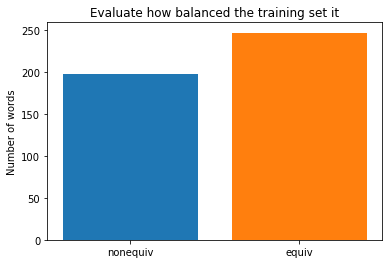

In [36]:
# Load training set after having manually classified it
dftrain = pd.read_csv('training_set_LD.csv')

# Find the Levenshtein distance between the reference word and normalized translated word
dftrain['LD'] = dftrain.apply(lambda x: LevenshteinDist(x['ref'], x['trans2']), axis=1)

# Show the training/test data
print('Training data:')
display(dftrain.head(15).style.hide(axis=0))
print()

# Partition the data
#(x_train, x_test, y_train, y_test) = train_test_split(np.array(dftrain['LD']), np.array(dftrain['equiv']), test_size=0.3, random_state=777, shuffle=True)
(dftrainset, dftestset) = train_test_split(dftrain, test_size=0.3, random_state=777, shuffle=True)

# Convert to numpy arrays to fit into model
x_train = np.array(dftrainset['LD'])
x_test = np.array(dftestset['LD'])
y_train = np.array(dftrainset['equiv'])

# Evaluate how balanced our training data is
equiv_words = dftrain[dftrain['equiv'] == 1].count()
nonequiv_words = dftrain[dftrain['equiv'] == 0].count()
plt.bar('nonequiv', nonequiv_words)
plt.bar('equiv', equiv_words)
plt.ylabel('Number of words')
plt.title('Evaluate how balanced the training set it')
plt.show()


#### Train and evaluate the model

Now we'll train the model using the training data, evaluate the test data against it, and score it for accuracy. Since we have a fairly balanced set, we can safely use accuracy as a reasonable metric.


In [37]:
# Instantiate a logistic regression model
logreg = LogisticRegression()

# Fit the model
logreg.fit(x_train.reshape(-1, 1), y_train)

# Predict values on the test set
y_pred = list(logreg.predict(x_test.reshape(-1, 1)))
dftestset = dftestset.reindex()
dftestset['pred'] = y_pred

# Score the predicted values against test data
dftestset['correct'] = dftestset.apply(lambda x: int(x.pred == x.equiv), axis=1)
acc = dftestset['correct'].sum() / dftestset.shape[0]
print('Accuracy: ' + str(round(acc * 100, 1)) + ' %')
print()
print('Logistic regression parameters: (coef=' + str(logreg.coef_[0][0]) + '), y-int=' + str(logreg.intercept_[0]) + ')')
print()


Accuracy: 94.0 %

Logistic regression parameters: (coef=-1.4813891483812027), y-int=7.219255423014009)



#### Affix normalization

The accuracy of the model is satisfactory, and we may well proceed with using it to compare languages. But maybe we can improve upon it. Because of the similarity in affixes between various languages, we might take normalization a step further and try to normalize each component of a word: its prefix, infix, and affix. That might improve the normalization strategy over simply finding Levenshtein distance. I'll leave that for a future project. But for now, I'll define some functions that will get us partway there.

The first thing would be to split a word into its affixes. But without developing a full knowledge about how affixes work in every language we're studdy (or if the language even has such a thing as affixes), we'll have to take a much naiver approach. For that, we'll simply take either the first few characters (if it's a prefix) or the last few characters (if it's a suffix) of the foreign word. But how many is a "few"?

In some languages, it will be easy. For example, in Spanish, the prefixes "mus" and "eum" are exactly the same as in English. In the Hungarian word "Múzeum," we can first cleave off the suffix "eum" and be left with "Múz," which is similar enough to English that we can say that "Múz" is the prefix of the word. But what about Scottish ("taigh-tasgaidh") or Welsh ("amgueddfa")?

For these cases (and in all cases in general), we should be able to use the same Levenshtein distance function to determine whether the affix is similar to English or not. This might be done by passing in a value to the function to indicate what kind of affix it is, along with a parameter to indicate how far into the word to extend our comparison.

For example, to compare the English word "museum" with the Italian word "museo," we could tell the function that we're looking for a suffix, that the English suffix is "eum," and to compare at most 2 characters different than the length of the English suffix. We'll call this difference in characters the "offset". In other words, the function would find a Levenshtein distance comparing the following suffixes:

| Offset | Suffix | Levenshtein Distance |
| ------ | ------ | ---------- |
| -2 | museo | 4 |
| -1 | useo | 4 |
| 0 | seo | 3 |
| 1 | eo | 2 |
| 2 | o | 3 |

Of these suffixes, we only want "eo" to match the English suffix "eum"; this corresponds to the minimum Levenshtein Distance (2) found out of all the offsets attempted. We'd have to do the same thing with word prefixes, as well. So finding the Levenshtein distances for varying offsets of the Italian word "museo" would result in:

| Offset | Prefix | Levenshtein Distance |
| ------ | ------ | ---------- |
| -2 | m | 2 |
| -1 | mu | 1 |
| 0 | mus | 0 |
| 1 | muse | 1 |
| 2 | museo | 2 |

Since "mus" is exactly the same in both English and Italian, the Levenshtein Distance is 0 for an offset of 0, and a perfect match is returned. And since we've decided that the Italian suffix "eo" is similar enough to the English "eum," we want to consider the entire Italian word to be functionally equivalent to the English word.

This is starting to look like a machine-learning problem. To that end, we might generate a list of affixes and manually label them as either "equivalent" or "not equivalent" to the English affix. As parameters of the ML model, we would pass in an offset and a threshold distance. We would then find the distances for prefix and suffix separately and compare them to the threshold distance. Distances lower than the threshold would be classified as "equivalent"; distances higher than the threshold would be classified as "not equivalent."

In the case of a match, we would store the affix for that language ("eo"), along with the language and the English version, "eum." We might start to think that anytime "eo" is found at the end of a word in Italian, it might be normalized to "eum" in English for comparison purposes. But at this point we can't say that with any reasonable certainty. To do that, we'd need more samples, which we already have from the words translated using the Yandex API. To illustrate with a few examples, we have these words for the English suffix "eum":

| English | language | Translation |
| ------- | -------- | ----------- |
| coliseum | Catalan | coliseum |
| mausoleum | Catalan | mausoleu |
| museum | Catalan | museu |
| coliseum | Italian | colisseo |
| mausoleum | Italian | mausoleo |
| museum | Italian | museo |
| coliseum | Latvian | coliseum |
| mausoleum | Latvian | mauzolejs |
| museum | Latvian | muzejs |

In Catalan, "mausoleu" follows the same pattern as "museu," since both words en in "eu." However, "coliseum" ends in "eum"--different than "eu" but the same as the English "eum." So our similarity function should take that into account. In Italian, all three suffixes nicely fall into the pattern in which the Italian equivalent of "eum" is "eo." Latvian is more similar to Catalan, in that "mausoleum" and "museum" have the suffixes "ejs," while "coliseum" is the same as the English word.


#### Function to find affixes

Now that we have a strategy, let's define a function to split a word into its candidate affixes using the "offset" parameter described above.


In [38]:
# Function to find the candidate affixes in a word based on the length of the English affix and an offset parameter
def findAffixes(affixType, affix, word, offset):
    # affixType: prefix, infix, or suffix
    # word: the word from which to return the affixes
    # offset: how deep into the foregin word we should search for the affix
    # returns: list of affixes of sizes determined by the offset parameters

    # Initialize
    affixes = []
    
    # Normalize the affix
    normAffix = normalizeWord2(affix)
    
    # Find the affix length
    affixLen = len(normAffix)
    
    # Handle cases where the offset is larger than the length of the affix
    if offset > len(word):
        offset = len(word)
    
    # Handle affix types differently
    if affixType == 'prefix':
        for i in range(affixLen - offset, affixLen + offset + 1):    # return letters from the beginning of the word
            if i <= len(word) and i >= 1:
                affixes.append(word[0:i])
    elif affixType == 'suffix':
        for i in range(affixLen - offset, affixLen + offset + 1):    # return letters from the end of the word
            if i <= len(word) and i >= 1:
                affixes.append(word[-i:])
    else:    # infixes - return letters from the middle of the word
        for i in range(int(len(word) / 2) - int(affixLen / 2) - offset, int(len(word) / 2) - int(affixLen / 2) + offset + 1):
            if i > 0 and (i + affixLen) <= len(word):
                affixes.append(word[i:i + affixLen])
    
    # Return the affix list
    return affixes


#### Function to count identical sequential characters

We'll run into a problem using simple Levenshtein distance in some cases. Using our previous example:

| English | Fake Word | Levenshtein Distance |
| --- | --- | --- |
| eum | eu | 2 |
| eum | eo | 2 |
| eum | east | 3 |
| eum | bla | 3 |
| eum | quz | 2 |

We really only want to consider the first two to be functionally equivalent; the other three are garbage. So, we'll want to weight affixes more heavily that have more identical characters either at the start (for prefixes) or the back (for affixes). To that end, we'll first define a function to count the number of identicals in a specified direction.


In [39]:
# Function to return number of characters that are the same in two strings
def countSame(str1, str2, dir):
    # str1: string 1
    # str2: string 2
    # dir: direction (forward or backward)
    # returns: number of identical characters in the specified direction
    
    if dir == 'backward':
        str1 = str1[::-1]
        str2 = str2[::-1]
    ct = 0
    if len(str1) < len(str2):
        for i in range(0, len(str1)):
            if str1[i] == str2[i]:
                ct += 1
            else:
                break
    else:
        for i in range(0, len(str2)):
            if str1[i] == str2[i]:
                ct += 1
            else:
                break
    return ct


Then we'll define a function to apply the count of identically ordered letters as a sort of "bonus" to the similarity score.


In [40]:
# Function to
def applyBonus(sim, affix1, affix2):
    
    # Get the length of the longest affix
    longest = len(affix1)
    if len(affix1) > len(affix2): longest = len(affix2)
    if longest < 1: longest = 1
    
    # Calculate the difference (one minus the similarity)
    dif = 1 - sim
    
    # Get the number of identical letters in the word in the forward direction
    ct = countSame(affix1, affix2, 'forward')
    
    # Calculate the bonus to be applied to the similarity score
    bonus = (dif / longest) * ct
    
    # Return the new similarity score
    return sim + bonus


#### Function to find similarity dividend

We'll want to normalize our similarity function so that we can compare affixes of different lengths. Therefore, we'll choose a dividend by which we'll divide the similarity value. But since we don't know what is the best one to use, we'll keep it open and allow it to be dynamically selected by, say, to pick a random example, an ML model.


In [41]:
# Function to perform the similarity calculation
def simDiv(dividendType, str1, str2):
    # dividendType: what to use as the dividend in the similarity calculation:
        # length of English word, length of foreign word, artithmetic mean of lengths, geometric mean of lengths, or harmonic mean of lengths
    # returns: similarity dividend value
    
    # Determine what the dividend will be based on the dividendType parameter
    dividend = len(str1)    # fail-safe
    if dividendType == 'str1': dividend = len(str1)
    if dividendType == 'str2': dividend = len(str2)
    if dividendType == 'arithmetic': dividend = (len(str1) + len(str2)) / 2
    if dividendType == 'geometric': dividend = math.sqrt(len(str1) * len(str2))
    if dividendType == 'harmonic':
        if len(str1) == 0 or len(str2) == 0:
            dividend = 1
        else:
            dividend = 2 / ((1 / len(str1)) + (1 / len(str2)))

    # Return the similarity probability
    return dividend


#### Function to calculate similarity

Now that we have a way to break apart a word into its candidate affixes and some components we'll need to use in calculating similarity, let's define the function to actually do it.


In [42]:
# Function to determine if two affixes are functionally equivalent
def similarity(affixType, eAffix, eWord, fWord, offset, dividendType):
    # affixType: prefix, infix, or suffix
    # eAffix: the affix in English
    # eWord: the English word
    # fWord: the foreign word
    # offset: how deep into the foregin word we should search for the affix
    # dividendType: what to use as the dividend in the similarity calculation:
        # length of English word, length of foreign word, artithmetic mean of lengths, geometric mean of lengths, or harmonic mean of lengths
    # simThreshold: the similarity probability above which the foreign affix can be considered functionally equivalent to the English affix
    # returns: tuple of similarities (prefix, affix)
    
    # Determine English affixes
    if affixType == 'prefix':
        
        # Determine English affixes
        eprefix = normalizeWord2(eAffix)
        esuffix = normalizeWord2(eWord[(len(eprefix) - len(eWord)):])
        einfix = ''
        
    elif affixType == 'suffix':
        esuffix = normalizeWord2(eAffix)
        eprefix = normalizeWord2(eWord[0:(len(eWord) - len(esuffix))])
        einfix = ''
    else:
        einfix = normalizeWord2(eAffix)
        infixLoc = eWord.find(einfix)
        if infixLoc == -1:
            print('\twarning: infix ' + einfix + ' not found in ' + eWord + '; splitting word in half to evaluate prefix and suffix')
            eprefix = normalizeWord2(eWord[0:int(len(eWord) / 2)])
            esuffix = normalizeWord2(eWord[-int(len(eWord) / 2) - (len(eWord) % 2):])
        else:
            eprefix = normalizeWord2(eWord[0:infixLoc])
            esuffix = normalizeWord2(eWord[len(eprefix) + len(einfix):])
    
    # Find candidate foreign affixes
    fprefixes = findAffixes('prefix', eprefix, fWord, offset)
    finfixes = findAffixes('infix', einfix, fWord, offset)
    fsuffixes = findAffixes('suffix', esuffix, fWord, offset)

    # Iterate three times (prefix, infix, suffix)
    simPrefix = 0
    simInfix = 0
    simSuffix = 0
    for i in range (0, 3):
        
        # Set affix variables
        if i == 0:
            curEngAffix = eprefix
            curForAffixes = fprefixes
        elif i == 1:
            curEngAffix = einfix
            curForAffixes = finfixes
        else:
            curEngAffix = esuffix
            curForAffixes = fsuffixes

        # Find the maximum similarity between affixes
        maxSim = 0
        for currForAffix in curForAffixes:
        
            # Calculate the Levenshtein distance
            ld = LevenshteinDist(curEngAffix, currForAffix)

            # Calculate the similarity score
            d = simDiv(dividendType, curEngAffix, currForAffix)
            if d == 0: d = 1
            sim = 1 - (ld / d)

            # Apply bonus if the affixes start with identical letters
            sim = applyBonus(sim, curEngAffix, currForAffix)

            # Set max
            if sim > maxSim:
                maxSim = sim

        # Set max similarity score
        if i == 0:
            simPrefix = maxSim
        elif i == 1:
            simInfix = maxSim
        else:
            simSuffix = maxSim

    # Return the similarity score
    if len(einfix) == 0:
        return (simPrefix + simSuffix) / 2
    else:
        return (simPrefix + simInfix + simSuffix) / 3


#### Similarity model

Perform similarity calcuations on the training set, then train the model based on the similarity scores. We'll run the model a number of times, varying the offset and dividend values. Then we'll score the model accuracies and see if it performs better than the model that only uses Levenshtein difference.


In [43]:
# Set model parameters
offsets = [0, 1, 2, 3, 4]
dividends = ['arithmetic', 'geometric', 'harmonic', 'str1', 'str2']
run_num = 0

# List to store results
results = []

# Iterate through offsets
for offset in offsets:
    
    # Iterate through dividends
    for dividend in dividends:
        
        # Print model parameters
        run_num += 1
        print('Run #' + str(run_num) + ': offset=' + str(offset) + ', dividend=' + dividend)
        
        # Find the similarity between the reference word and normalized translated word
        dftrain['sim'] = dftrain.apply(lambda x: similarity(x['type'], x['affix'], x['ref'], x['trans2'], offset, dividend), axis=1)
        #display(dftrain.head(15).style.hide(axis=0))

        # Partition the data
        #(x_train, x_test, y_train, y_test) = train_test_split(np.array(dftrain['LD']), np.array(dftrain['equiv']), test_size=0.3, random_state=777, shuffle=True)
        (dftrainset, dftestset) = train_test_split(dftrain, test_size=0.3, random_state=777, shuffle=True)
        
        # Convert to numpy arrays to fit into model
        x_train = np.array(dftrainset['sim'])
        x_test = np.array(dftestset['sim'])
        y_train = np.array(dftrainset['equiv'])

        # Instantiate a logistic regression model
        logreg2 = LogisticRegression()

        # Fit the model
        logreg2.fit(x_train.reshape(-1, 1), y_train)

        # Predict values on the test set
        y_pred = list(logreg2.predict(x_test.reshape(-1, 1)))
        dftestset = dftestset.reindex()
        dftestset['pred'] = y_pred

        # Score the predicted values against test data
        dftestset['correct'] = dftestset.apply(lambda x: int(x.pred == x.equiv), axis=1)
        acc = dftestset['correct'].sum() / dftestset.shape[0]
        print('\tAccuracy: ' + str(round(acc * 100, 1)) + ' %')
        print('\tLogistic regression parameters: (coef=' + str(logreg2.coef_[0][0]) + '), y-int=' + str(logreg2.intercept_[0]) + ')')
        print()
        
        # Add the results to the dict
        results.append({'run': run_num, 'offset': offset, 'dividend': dividend, 'accuracy': acc})


Run #1: offset=0, dividend=arithmetic
	Accuracy: 94.0 %
	Logistic regression parameters: (coef=6.252940534628392), y-int=-2.5809379336349427)

Run #2: offset=0, dividend=geometric
	Accuracy: 94.0 %
	Logistic regression parameters: (coef=6.252940534628392), y-int=-2.5809379336349427)

Run #3: offset=0, dividend=harmonic
	Accuracy: 94.0 %
	Logistic regression parameters: (coef=6.252940534628392), y-int=-2.5809379336349427)

Run #4: offset=0, dividend=str1
	Accuracy: 94.0 %
	Logistic regression parameters: (coef=6.252940534628392), y-int=-2.5809379336349427)

Run #5: offset=0, dividend=str2
	Accuracy: 94.0 %
	Logistic regression parameters: (coef=6.252940534628392), y-int=-2.5809379336349427)

Run #6: offset=1, dividend=arithmetic
	Accuracy: 95.5 %
	Logistic regression parameters: (coef=6.513934757377793), y-int=-3.4316408233659126)

Run #7: offset=1, dividend=geometric
	Accuracy: 95.5 %
	Logistic regression parameters: (coef=6.511042584117928), y-int=-3.4203193782036574)

Run #8: offset=

#### Compare model results

Display the model results.


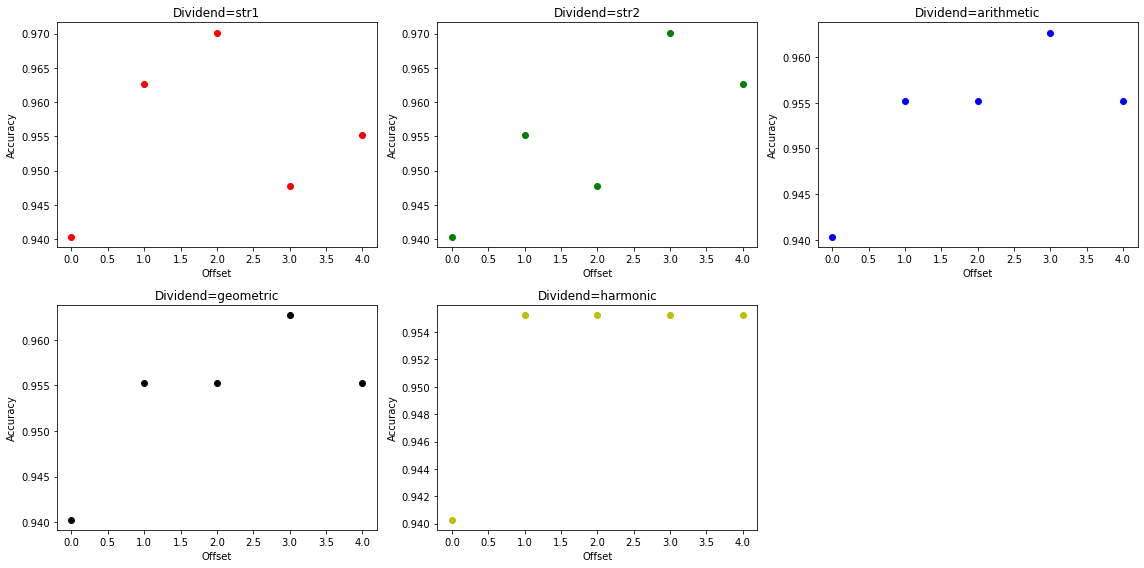

In [44]:
# Convert result list to data frame
dfresults = pd.DataFrame(results)
dfresults = dfresults.sort_values(['accuracy', 'run'], ascending=[False, True])
display(dfresults.style.hide(axis=0))

# Graph results
fig, axes = plt.subplots(figsize=(16, 8))
cmap = {'str1': 'r', 'str2': 'g', 'arithmetic': 'b', 'geometric': 'k', 'harmonic': 'y'}
dfresults['div_color'] = dfresults.apply(lambda x: cmap[x['dividend']], axis=1)
ct = 0
for label in cmap.keys():
    ct += 1
    plt.subplot(2, 3, ct)
    dfsubset = dfresults[dfresults['dividend'] == label]
    plt.scatter(dfsubset['offset'], dfsubset['accuracy'], label=label, color=cmap[label])
    plt.xlabel('Offset')
    plt.ylabel('Accuracy')
    plt.title('Dividend=' + label)
fig.tight_layout()
plt.show()

# Save the best parameters
dfresults.reset_index()
bestOffset = dfresults.iloc[0]['offset']
bestDividend = dfresults.iloc[0]['dividend']


#### Model the full data set

Now that we have a model, we can run it against the full data set.


In [45]:
# Find the Levenshtein distance in the full dataset
dftrans['LD'] = dftrans.apply(lambda x: LevenshteinDist(x.word, x.trans2), axis=1)

# Find the similarity between the reference word and normalized translated word
dftrans['sim'] = dftrans.apply(lambda x: similarity(x['type'], x['affix'], x['ref'], x['trans2'], bestOffset, bestDividend), axis=1)

# Convert to numpy arrays to fit into model
x_train = np.array(dftrainset['sim'])
x_test = np.array(dftestset['sim'])
y_train = np.array(dftrainset['equiv'])

# Instantiate a logistic regression model
logreg2 = LogisticRegression()

# Fit the model
logreg2.fit(x_train.reshape(-1, 1), y_train)

# Predict values on the full data set
x_full = np.array(dftrans['sim'])
y_full = list(logreg2.predict(x_full.reshape(-1, 1)))
dftrans['equiv'] = y_full

# Set the normalized word to be the reference word if it was predicted by the model to be functionally equivalent
dftrans['trans3'] = dftrans.apply(lambda x: x['ref'] if x['equiv'] == 1 else x['trans2'], axis=1)
print('Normalized data:')
display(dftrans.head(15).style.hide(axis=0))


Normalized data:


#### Normalization function

Now that we have a model to find the functional equivalent of translated words, use it to build an even more robust normalization function.


In [46]:
# Expanded normalization function to include functional equivalency;
# this one will be slightly different because we'll need to know the language as well as the word
def normalizeWord3(word, lang):
    
    # Assign word to a temporary variable (necessary to prevent array boundary errors) and convert to lower case
    tmp = word.lower()
    
    # Initialize the new, normalized word
    r = ''
    
    # First pass to normalize characters
    for letter in tmp:
        repl = letter
        try:
            repl = dfnewletters[dfnewletters['letter'] == letter].iloc[0]['newletter']
        except:
            # This will usually mean that the letter isn't in the list, e.g. a hyphen;
            # in these cases, just use the original letter.
            pass
        r += repl    # replace with approximate ASCII equivalent character
    
    # Second pass to normalize digraphs and trigraphs
    for digraph, repl in digraphs.items():
        r = r.replace(digraph, repl)
    
    # Look up the functional equivalent of the word
    fe = dftrans[(dftrans['lang'] == lang) & (dftrans['trans2'] == r)]['trans3']
    
    # Return the normalized word
    if fe.shape[0] == 0:
        return r
    else:
        return fe.iloc[0]

# Tokenize the words using the new normalization function
w3 = tokenizeWords(normalizeWord3)


#### Compare to previous run

Re-evaluate overlapping word counts after a third pass of normalization.


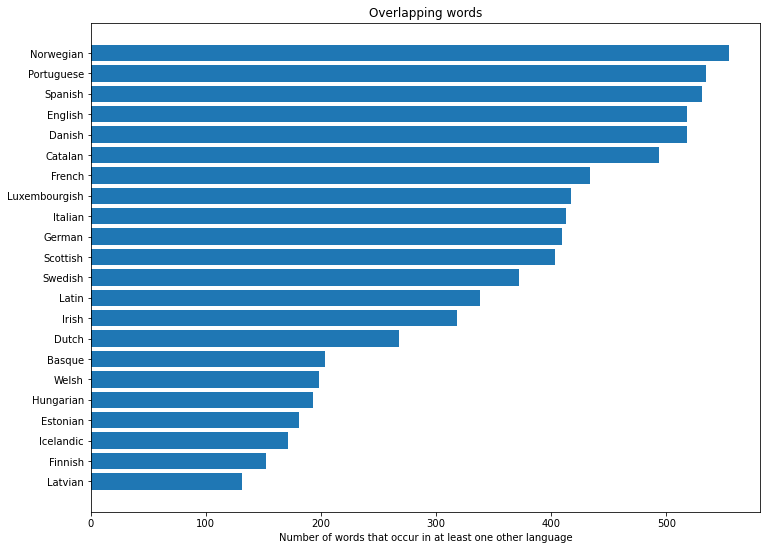

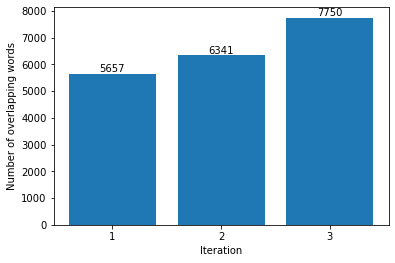

In [47]:
# Regenerate graph using the new tokenized words
g3 = genGraph(w3, False)

# Regenerate the dataframe, again looking at overlapping word counts
df3, dfoverlap3 = regenDf(w3, g3, dfoverlap2, 2, False)

# Display bar chart showing progress after each normalization step
iterationSummary(dfoverlap3, 3)


As shown above, we made a substantial gain from this round of normalization (about 1,400 words).


#### Graph projections

As before, we'll need to project languages on the main graph to make any useful comparisons.


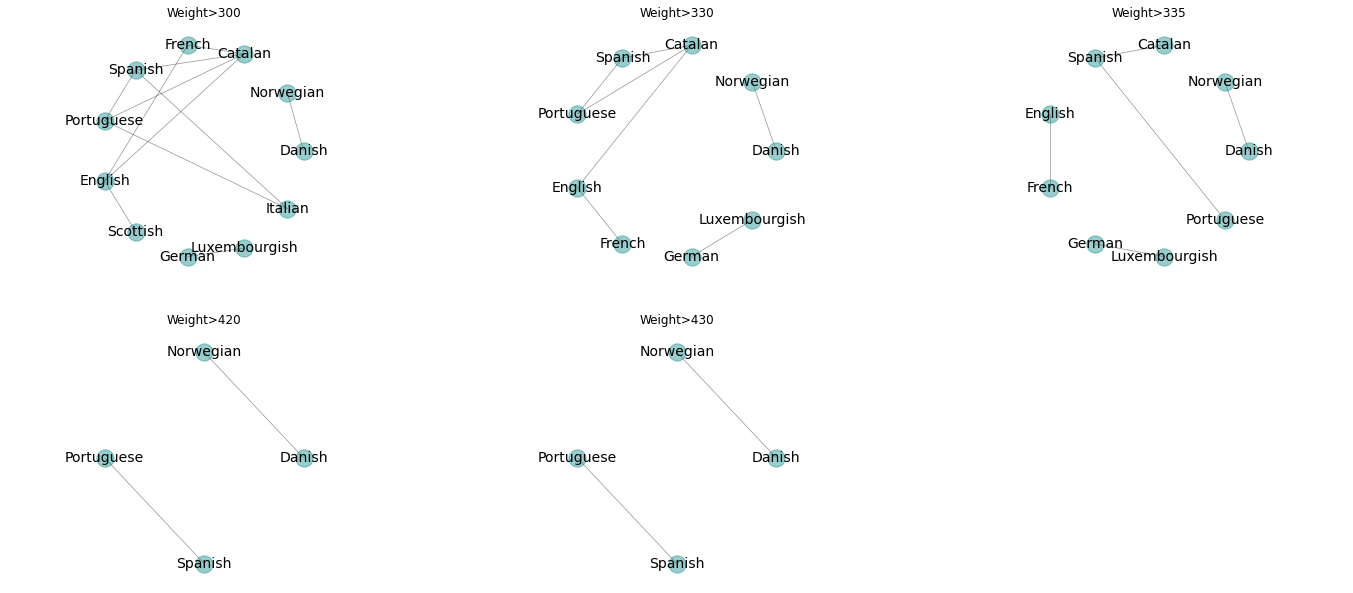

In [76]:
# Project languages onto main graph
gp3 = projectNodes(g3, side='langs')

# Draw projected graph
#drawProjectedGraph(gp3)

# Define weights we're interested in
weights=[300, 330, 335, 420, 430]

# Draw trimmed graphs
drawTrimmedGraphs(gp3, (24, 16), '33', weights)


#### Connected component subgraphs

We'll look at the connected component subgraphs again to more clearly evaluate which languages are similar.


Weight=300


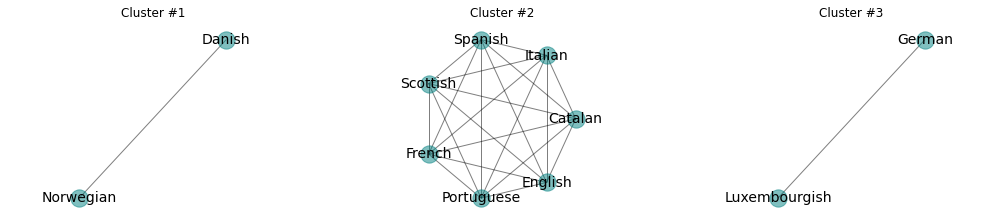


Weight=330


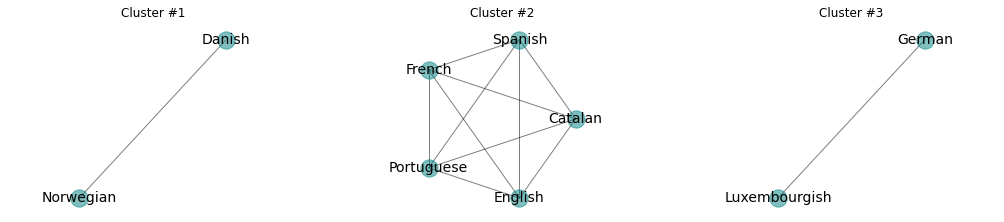


Weight=335


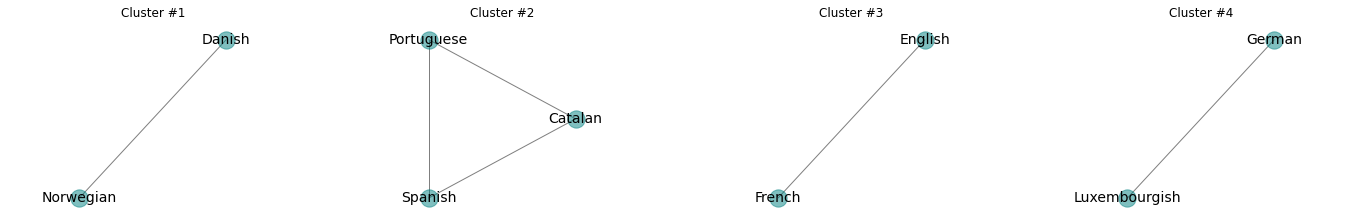


Weight=420


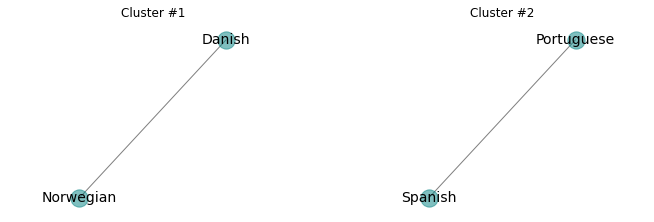


Weight=430


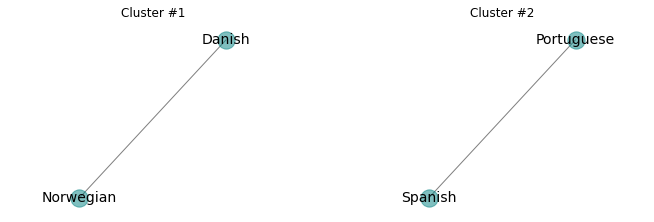

In [77]:
# Draw the subgraphs with generic cluster names
drawSubgraphs(gp3, weights, [])


Now it seems we have some different clusters than before. Let's compare them. The graphs at weight 335 are particularly interesting. During earlier rounds of normalization, we saw a cluster of languages in the Britsh Isles that were similar: English, Irish, Scottish, and their root language, Latin. With the additional normalization, more similarities are detected among English and French than those between the languages spoken in the Briish Isles. This indicates that English, Irish, and Scottish experienced a greater divurgence from each other (and from their Latin root) and a greater absorption of French words into English (and vice versa). In addition, we see Catalan emerging as a close relative of Spanish and Portuguese, which makes intuitive sense given their geographic proximity.


After first round of normalization:
Weight=180


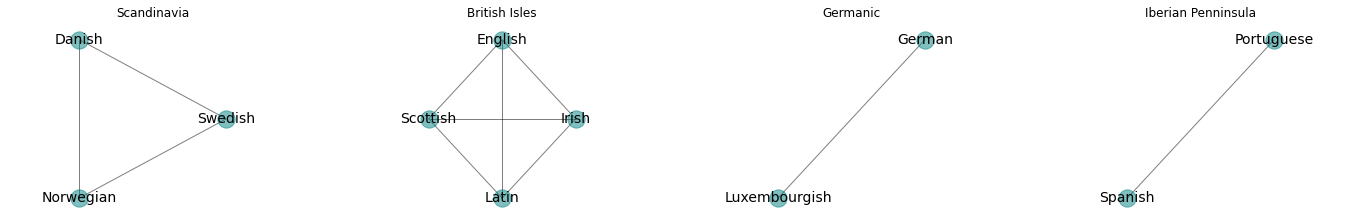



After last round of normalization:
Weight=335


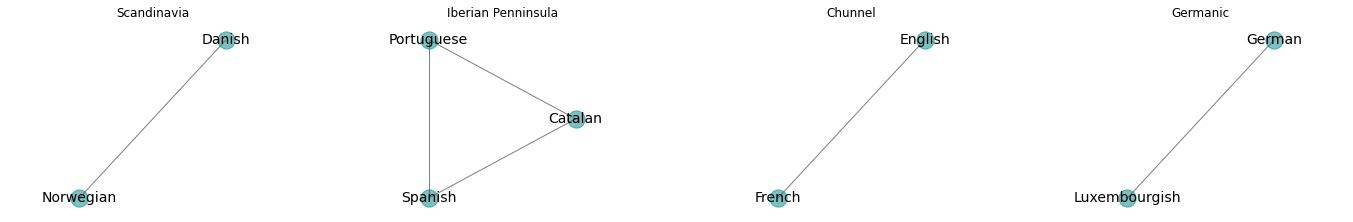

In [79]:
# After first round of normalization
print('After first round of normalization:')
drawSubgraphs(gp, [180], [['Scandinavia', 'British Isles', 'Germanic', 'Iberian Penninsula']])
print()

# After last round of normalization
print('After last round of normalization:')
drawSubgraphs(gp3, [335], [['Scandinavia', 'Iberian Penninsula', 'Chunnel', 'Germanic']])
print()


This seems to indicate that more normalization will help find similarities between certain languages such as English and French, but it may overshadow the similarities between certain other languages. For example, Swedish dropped out of the Scandinavian cluster on the last round of normalization. While that doesn't mean that it is any less similar to Norwegian and Danish, it only means that the extra normalization raised the level of similarity between French and English.


### Quantitative Comparisons

Now that we've taken a qualitative look at how similar languages can be grouped together, we'll take a more quantitative approach by using centrality metrics. Specifically, we'll look at the following:

1. Degree: Which language has the most total words in common with other all the other languages?
2. Closeness: Which language is the closest to all the other languages?
3. Betweenness: Are there any languages that serve as bridges between other groups of languages?
4. Eigenvector: Which languages are connected to other languages that have the highest degrees?

Recall that the graph showing the bipartite connections between languages is a "complete" graph; i.e., all languages have at least one word in common with every other language studied. Therefore, when we're evaluating centrality metrics, we'll be using weighted values. If we didn't, the metric for each language would be exactly the same as all the other languages, which wouldn't be terribly interesting.

To start with, we'll define a function to display our metrics in a prettier format.


In [51]:
# Function to display nodes in a data frame
def nodeToDf(cent, sg, metricName, topn):
    # cent=sorted list of centrality metrics
    # sg=subgraph
    # metricName=the name of the metric, e.g. degree, closeness, etc
    # topn=top n values to display

    # first create empty data frame
    df = pd.DataFrame(columns=['Rank', 'Language', metricName])
    
    # loop through each centrality entry, adding each one to the data frame
    for i, b in enumerate(cent):
        if i >= topn: break    # only use the top five
        #if metricName == 'Degree' or metricName == 'Closeness':    # uses tuples instead of scalars
        #    tmpd = {'Rank': [i+1], 'Language': [b[0]], metricName: [b[1]]}    # add rank, node name, and metric
        #else:
        #    tmpd = {'Rank': [i+1], 'Language': [b], metricName: [cent[b]]}    # add rank, node name, and metric
        tmpd = {'Rank': [i+1], 'Language': [b[0]], metricName: [b[1]]}    # add rank, node name, and metric
        df = pd.concat([df, pd.DataFrame.from_dict(tmpd)], ignore_index=True)
    print()
    dfstyle = df.style.hide(axis=0)    # hide index column
    display(dfstyle)


#### Degree centrality

Calculate the degree centrality of each language, weighted by the number of words in common between languages. The number represents the number of words in that language that it has in common with at least one other language.


In [52]:
# Languages by weighted degree centrality
cent = sorted(nx.degree(gp3, weight='weight'), key=lambda k: k[1], reverse=True)
print('Languages by ordered by degree centrality:')
nodeToDf(cent, gp3, 'Degree', 99)
print()


Languages by ordered by degree centrality:



#### Ego graphs

The metrics in the table above show a total count of words that each language has in common with all the other languages. But what about which languages have the most words in common with other languages on an individual basis? The best way to show this is to use an Ego graph to take a look at some of the languages rank in the top 5 by degree.

First, since some of the metrics require our graph to have distances, we'll create a function to calculate distance as a function of weight. We'll pick the edge with the largest weight, then subtract the weight of each edge from it, adding one to avoid dividing by zero. This will be the distance. We'll also calculate normalized weights and distances while we're at it for ease of use.

Then we'll draw some ego graphs for various languages and generate a table of languages with the most number of similar words.


In [99]:
# Function to calculate distance
def calcDist(g):
    #g: graph object
    #returns: graph object with distance added as an edge parameter
    
    # Find max weight so we can normalize the weights
    maxwt = 0
    for e in g.edges(data=True):
        if e[2]['weight'] > maxwt: maxwt = e[2]['weight']
    maxwt += 1    # to avoid division by zero
    
    # Normalized values
    for e in g.edges(data=True):
        e[2]['dist'] = maxwt - e[2]['weight']
        e[2]['weight_norm'] = e[2]['weight'] / maxwt
        e[2]['dist_norm'] = 1 - e[2]['weight_norm']
    
    # Return the graph object
    return g
    
# Function to generate the ego graph for a specified language
def genEgo(g, lang, radius, weight, distance, thin):
    # g: graph object
    # lang: language
    # radius: distance at which to clip the graph
    # weight: parameter to use for weight calculations
    # distance: parameter to use for distance calculations
    # thin: thin out the graph by removing edges not connected to the ego node
    # returns: ego graph object

    # Generate the ego graph
    eg = nx.ego_graph(g, lang, center=True, undirected=True, distance=distance, radius=radius)
    labels=dict(eg.nodes())
    for k in labels.keys(): labels[k] = k

    # Graph options
    options = {
        'node_color': 'teal',
        'node_size': 100,
        'width': .25,
        'alpha': 0.4
    }
    ego_options = {
        'node_size': 400,
        'node_color': 'r',
        'alpha': 0.6
    }
    
    # If specified, thin out the graph by removing the edges not connected to the ego node
    if thin == True:
        for e in eg.edges():
            if e[0] != lang and e[1] != lang: eg.remove_edge(e[0], e[1])
    
    # Plot graph
    plt.figure(1, figsize=(12, 8))
    pos = nx.spring_layout(eg, weight=weight, dim=2, seed=777)
    nx.draw_networkx_labels(eg, pos=pos, labels=labels, font_size=14, font_color='black')
    nx.draw_networkx_nodes(eg, pos, nodelist=[lang], **ego_options)
    nx.draw(eg, pos=pos, **options)
    plt.margins(x=0.4)
    plt.show()
    
    # Return the ego graph
    return eg

# Calculate distances (needed for ego graph calculations)
gp3 = calcDist(gp3)


#### English

Since English tops the list of languages ranked by degree centrality, we'll start there. Draw the ego graphs for English.


Ego graph for English (all nodes shown):


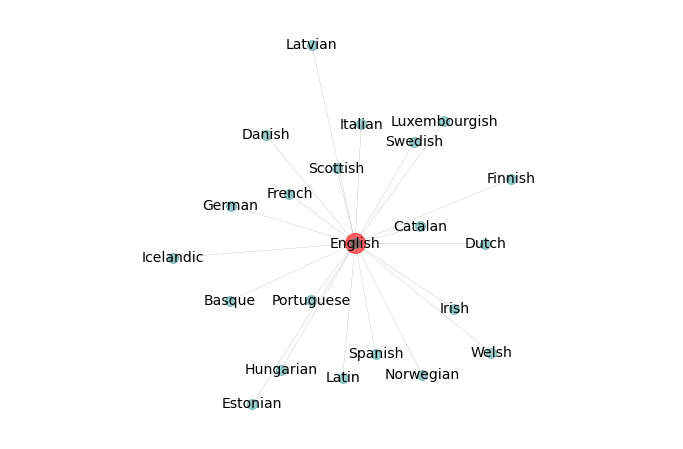


Ego graph for English (most similar nodes shown):


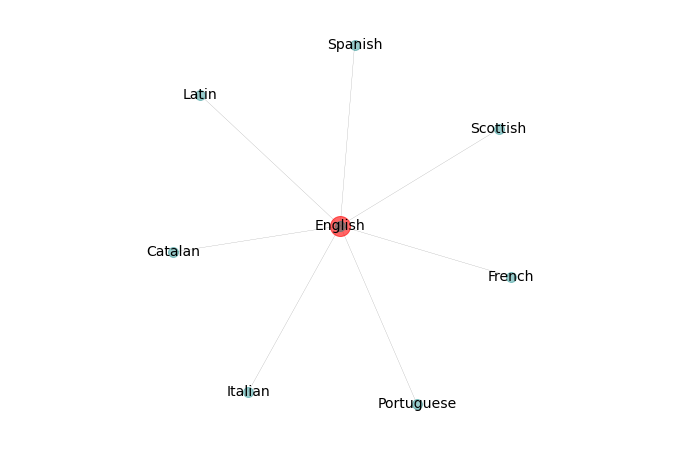


Words that English has in common with other languages:


In [100]:
# Draw Ego graph for English (all nodes)
print('Ego graph for English (all nodes shown):')
eg = genEgo(gp3, 'English', radius=1, weight='weight', distance='dist_norm', thin=True)
print()

# Draw Ego graph for English (most similar nodes)
print('Ego graph for English (most similar nodes shown):')
eg = genEgo(gp3, 'English', radius=0.44, weight='weight', distance='dist_norm', thin=True)
print()

# Get word counts in other languages that are common to English
dfeng = genWeights(w3, g3, ['English'])
dfeng.sort_values(['English'], ascending=False, inplace=True)
print('Words that English has in common with other languages:')
display(dfeng.head(len(eg.nodes()) - 1).style.hide(axis=0))
print()


#### Spanish

Now we'll do the same thing for Spanish, since it's a common language worldwide.


Ego graph for Spanish (all nodes shown):


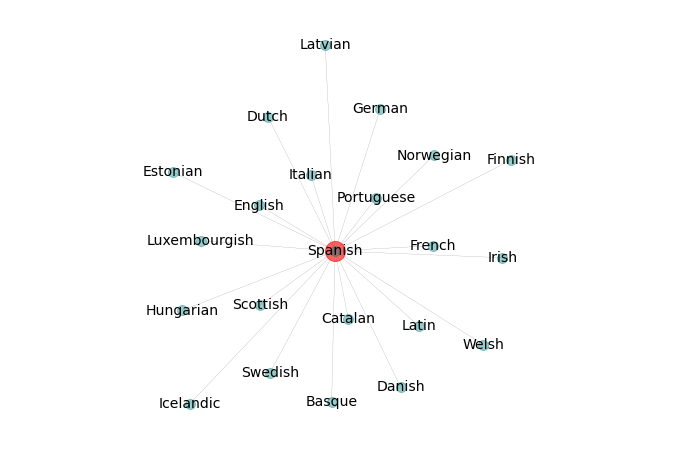


Ego graph for Spanish (most similar nodes shown):


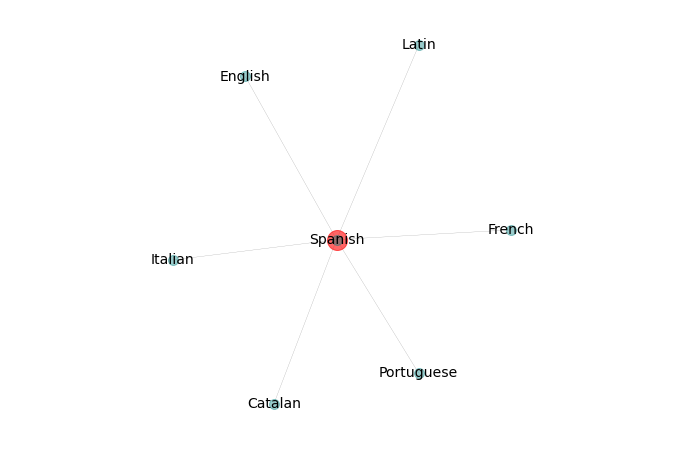


Words that Spanish has in common with other languages:


In [55]:
# Draw Ego graph for Spanish (all nodes)
print('Ego graph for Spanish (all nodes shown):')
eg = genEgo(gp3, 'Spanish', radius=1, weight='weight', distance='dist_norm', thin=True)
print()

# Draw Ego graph for Spanish (most similar nodes)
print('Ego graph for Spanish (most similar nodes shown):')
eg = genEgo(gp3, 'Spanish', radius=.5, weight='weight', distance='dist_norm', thin=True)
print()

# Get word counts in other languages that are common to Spanish
dfeng = genWeights(w3, g3, ['Spanish'])
dfeng.sort_values(['Spanish'], ascending=False, inplace=True)
print('Words that Spanish has in common with other languages:')
display(dfeng.head(len(eg.nodes()) - 1).style.hide(axis=0))
print()


#### Icelandic

Since Icelandic has the lowest degree centrality, investigate its ego graph to see if we can figure out why.


Ego graph for Icelandic (all nodes shown):


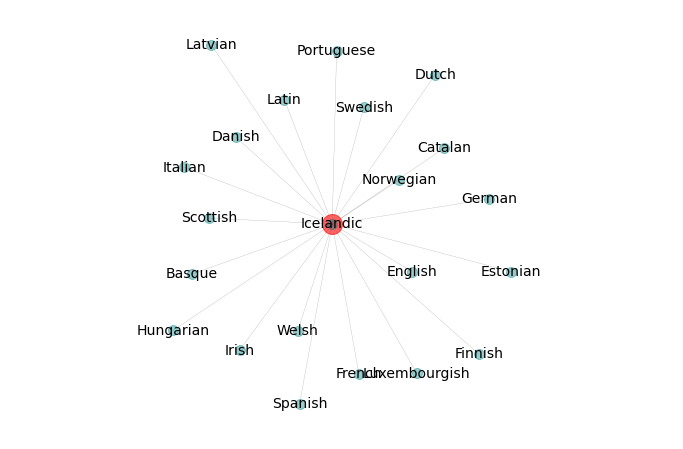


Ego graph for Icelandic (most similar nodes shown):


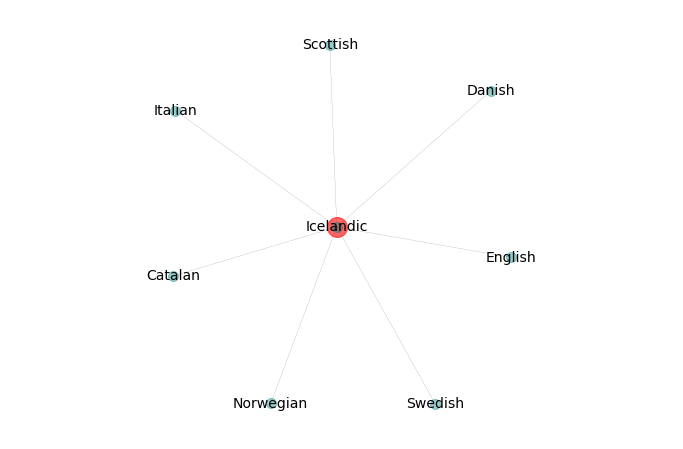


Words that Icelandic has in common with other languages:


In [56]:
# Draw Ego graph for Icelandic (all nodes)
print('Ego graph for Icelandic (all nodes shown):')
eg = genEgo(gp3, 'Icelandic', radius=1, weight='weight', distance='dist_norm', thin=True)
print()

# Draw Ego graph for Icelandic (most similar nodes)
print('Ego graph for Icelandic (most similar nodes shown):')
eg = genEgo(gp3, 'Icelandic', radius=.785, weight='weight', distance='dist_norm', thin=True)
print()

# Get word counts in other languages that are common to Icelandic
dfeng = genWeights(w3, g3, ['Icelandic'])
dfeng.sort_values(['Icelandic'], ascending=False, inplace=True)
print('Words that Icelandic has in common with other languages:')
display(dfeng.head(len(eg.nodes()) - 1).style.hide(axis=0))
print()


Let's take a look at some of the words that overlap Icelandic.


In [57]:
# Walk through each edge in the graph
iceWords = {}    # dict to store words that other language have in common with Icelandic
for e in g3.edges(data=True):
    # If the edge is connected to the Icelandic node, add it to the dict
    if e[0] == 'Icelandic':
        iceWords[e[1]] = [nx.degree(g3, e[1])]
    elif e[1] == 'Icelandic':
        iceWords[e[0]] = [nx.degree(g3, e[0])]
        
# Convert the dct to a data frame, rename the column, sort it, and display the first few rows
dfice = pd.DataFrame.from_dict(iceWords, orient='index')
dfice = dfice.rename(columns={0: 'overlapping_languages'})
dfice.sort_values(['overlapping_languages'], ascending=False, inplace=True)
display(dfice.head(15))


overlapping_languages
arachnofobia                     22
trifecta                         22
polyester                        22
megadose                         22
eufobia                          22
homofone                         22
francofilia                      22
symbiotic                        21
biomas                           21
interstate                       21
monotone                         21
exoskeleton                      21
megafone                         21
telekinesis                      21
intrasttate                      21

These all seem to have Latin or Greek roots, which is pretty typical of European languages.


#### Closeness centrality

Another common centrality metric is closeness. This is an indicator of which nodes have the lowest average distance to all other nodes. This also takes into account paths through other nodes. But for this study, closeness should be identical to degree because all nodes are connected to each other in a complete graph. We'll run the numbers anyway to confirm. We'll also display an ego graph for the top node (English) to illustrate how every node is connected to every other node.


Languages ordered by closeness centrality:




Ego graph for English (all nodes shown):


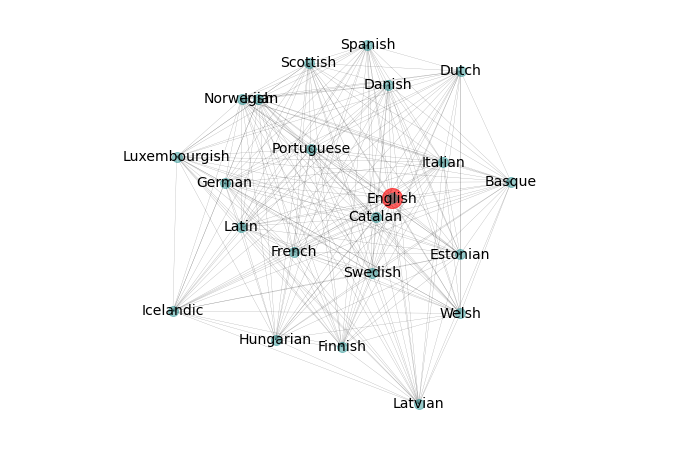

In [58]:
# Show languages by closeness centrality
cent = nx.closeness_centrality(gp3, distance='dist')
cent_sorted = sorted(cent.items(), key=lambda item: item[1], reverse=True)
print('Languages ordered by closeness centrality:')
nodeToDf(cent_sorted, gp3, 'Closeness', 99)
print()

# Draw Ego graph for English (all nodes, without thinning)
print('Ego graph for English (all nodes shown):')
eg = genEgo(gp3, 'English', radius=1, weight='weight', distance='dist_norm', thin=False)
print()


#### Betweenness

Nodes with a high netweenness centrality indicate that they form bridges or bottlenecks between other nodes. Betweenness is a measure of how many shortest paths between other nodes that a nodes is on. Since this is a weighted graph, shortest path is measured by minimizing the distance between nodes.


In [59]:
# Show languages by betweenness centrality
cent = nx.betweenness_centrality(gp3, normalized=True, weight='dist')
cent_sorted = sorted(cent.items(), key=lambda item: item[1], reverse=True)
print('Languages ordered by betweenness centrality:')
nodeToDf(cent_sorted, gp3, 'Betweenness', 99)
print()


Languages ordered by betweenness centrality:



It is interesting that Norwegian and Spanish are the only languages having a betweenness centrality greater than zero. This is most likely because this is a complete network graph in which all nodes are connected to all other nodes. Therefore, only the languages that are most similar would likely have any significant betweenness value. We'll draw the ego graph for Norway to investigate.


Ego graph for Norwegian (all nodes shown):


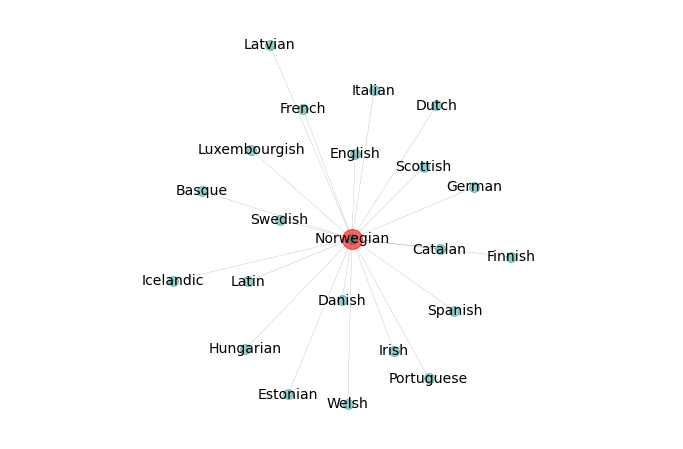


Ego graph for Norwegian (closest nodes):


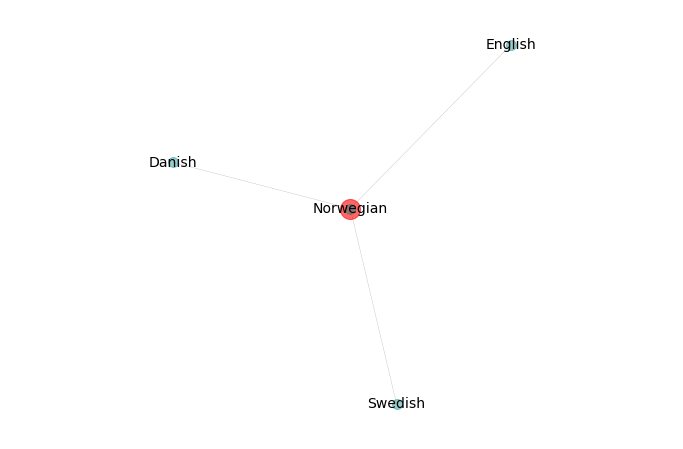


Words that Norwegian has in common with other languages:


In [60]:
# Draw Ego graph for Norwegian (all nodes)
print('Ego graph for Norwegian (all nodes shown):')
eg = genEgo(gp3, 'Norwegian', radius=1, weight='weight', distance='dist_norm', thin=True)
print()

# Draw Ego graph for Norwegian (closest nodes)
print('Ego graph for Norwegian (closest nodes):')
eg = genEgo(gp3, 'Norwegian', radius=.5, weight='weight', distance='dist_norm', thin=True)
print()

# Get word counts in other languages that are common to Norwegian
dfeng = genWeights(w3, g3, ['Norwegian', 'Danish', 'Swedish', 'English'])
dfeng.sort_values(['Norwegian'], ascending=False, inplace=True)
print('Words that Norwegian has in common with other languages:')
display(dfeng.head(len(eg.nodes()) - 1).style.hide(axis=0))
print()


Let's also investigate the closest neighbors to Spanish.


Ego graph for Spanish (most similar nodes shown):


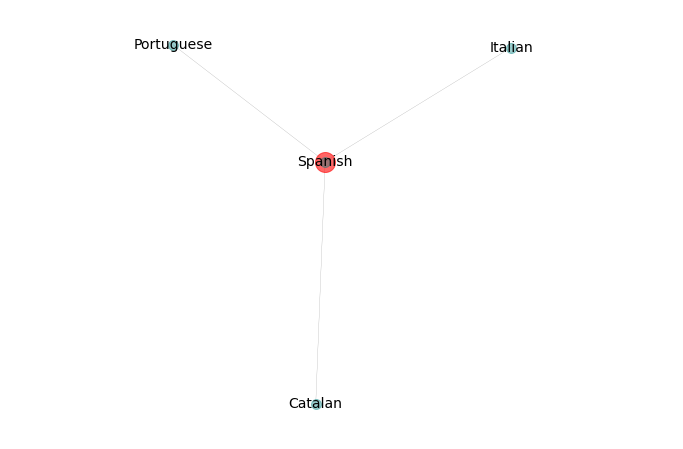

In [61]:
# Draw Ego graph for Spanish (most similar nodes)
print('Ego graph for Spanish (most similar nodes shown):')
eg = genEgo(gp3, 'Spanish', radius=.35, weight='weight', distance='dist_norm', thin=True)
print()


From the above, it is reasonable to conclude that Norwegian is similar enough to Danish, Swedish, and English that it would lie on the shortest path between each of those nodes, thereby giving it a betweenness centrality above zero. Likewise, Spanish is simliar enough to Catalan, Italian, and Portuguese that the betweenness centrality metric makes sense.


#### Eigenvector centrality

Eigenvector centrality is a measure of how well connected a node's neighbors are. The node itself doesn't necessarily have to have a high degree centrality; only its neighbors are taken into consideration. Since this is a complete graph, we'd expect eigenvector centrality to be similar to degree centrality.


In [62]:
# Show languages by eigenvector centrality
cent = nx.eigenvector_centrality(gp3, weight='weight')
cent_sorted = sorted(cent.items(), key=lambda item: item[1], reverse=True)
print('Languages ordered by eigenvector centrality:')
nodeToDf(cent_sorted, gp3, 'Eigenvector', 99)
print()


Languages ordered by eigenvector centrality:



As expected for a complete network graph, eigenvector centrality yields the same ranking as degree centrality.


#### Percentage overlap

For a final quantitative look, we'll generate a table of weights showing percentages of words that overlap each pair of languages.


In [85]:
# Generate weights
print('Overlapping words in each language pair (percentages):')
display(genWeights(w3, g3, [], pct=True).style.hide(axis=0))


Overlapping words in each language pair (percentages):


### Most common words

So far, we've only looked at which languages have the most number of similar words across all the languages. We'll take a brief look at which words are most common across the languages. To do that, we'll have to project words onto the full graph. Then we'll draw a graph showing the words that appear in the most number of languages. Recall that these are normalized words, so the actual words may be slightly different in each language, but it is similar enough that our normalization strategy deemed them functionally equivalent.


#### Graph projections

As we did with languages, we'll need to project words onto the main graph to make any comparisons.


In [63]:
# Project words onto the full graph
gpw = projectNodes(g3, side='words')


#### Draw projected graphs

Now we'll draw graphs trimmed at various weights to see which words are associated with the most languages.


Words that appear in the number of languages specified by "weight":


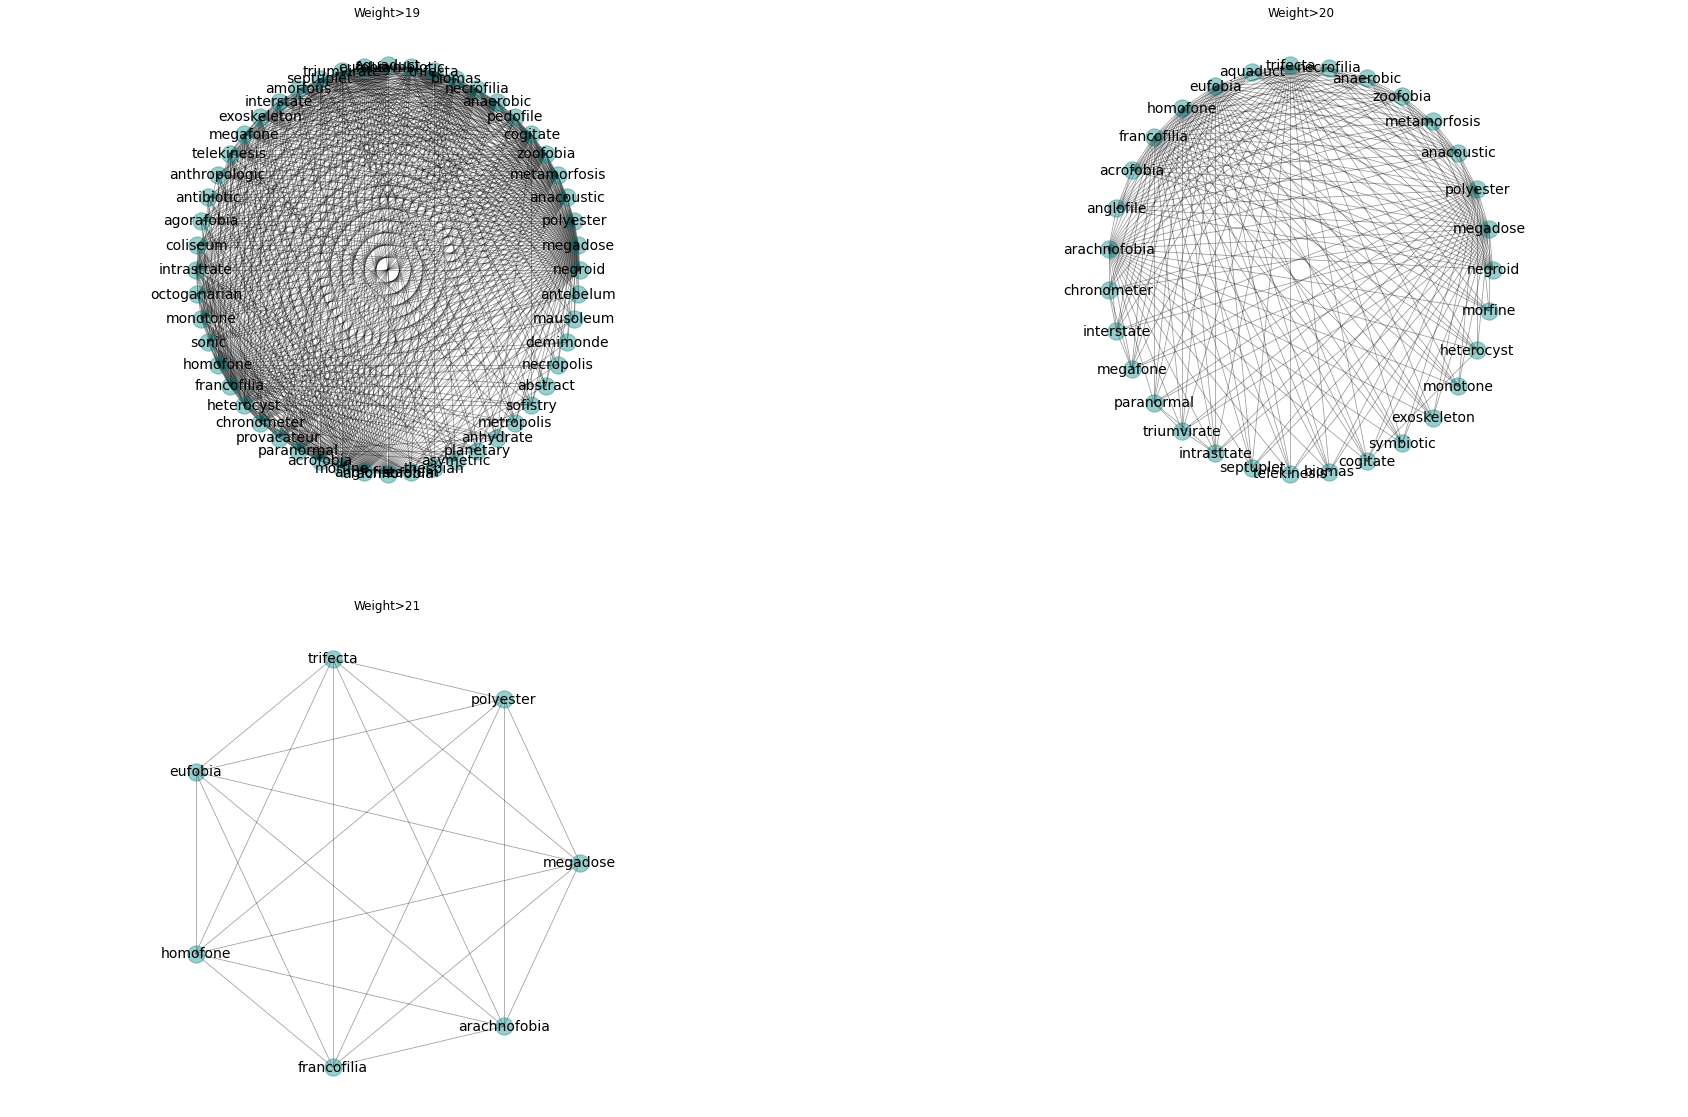

In [64]:
# Draw graph trimmed at 19 languages
print('Words that appear in the number of languages specified by "weight":')
drawTrimmedGraphs(gpw, (30, 20), '22', [19, 20, 21])


We'll choose one of the words to look at more closely: "biomass." Let's find the languages that it appears in. We'll first look at where it appeared when the only normalization we did was converting to lower case, then we'll see how it changed after normalizing by functional equivalency.


Ego graph for biomass (no normalization except converting to lower case):


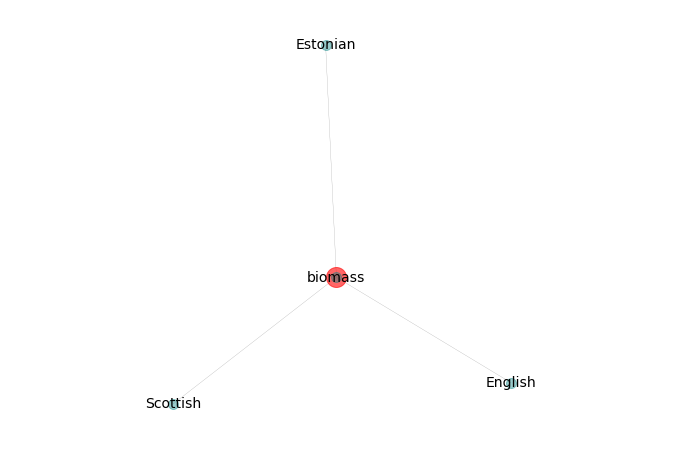

3 languages

Ego graph for biomas (after character and digraph/trigraph normalization):


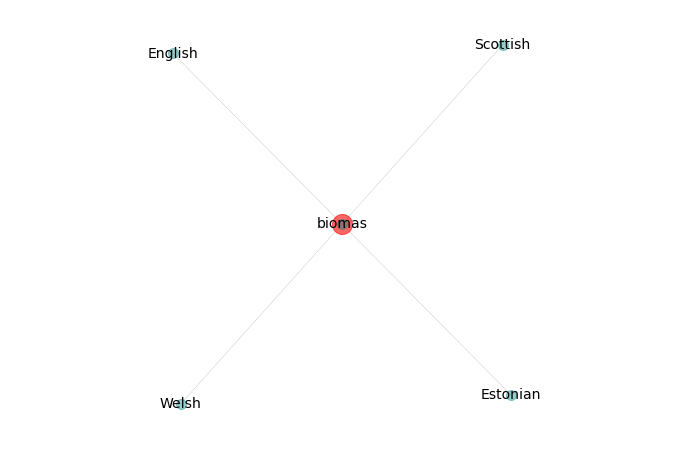

4 languages

Ego graph for biomas (noramlized by functional equivalency):


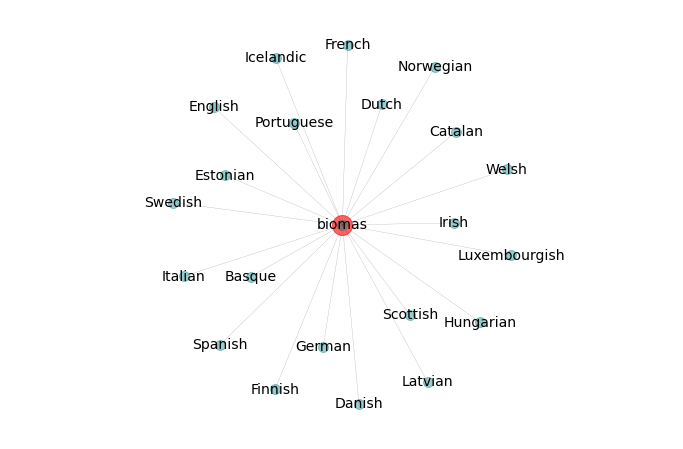

21 languages



In [65]:
# Calculate distances for graphs
calcDist(gpw)

# Draw Ego graph for normalization round #1
print('Ego graph for biomass (no normalization except converting to lower case):')
eg = genEgo(g, 'biomass', radius=1, weight='weight', distance='dist_norm', thin=True)
print(len(eg.nodes()) - 1, 'languages')
print()

# Draw Ego graph for normalization round #2
print('Ego graph for biomas (after character and digraph/trigraph normalization):')
eg = genEgo(g2, 'biomas', radius=1, weight='weight', distance='dist_norm', thin=True)
print(len(eg.nodes()) - 1, 'languages')
print()

# Draw Ego graph for normalization round #3
print('Ego graph for biomas (noramlized by functional equivalency):')
eg = genEgo(g3, 'biomas', radius=1, weight='weight', distance='dist_norm', thin=True)
print(len(eg.nodes()) - 1, 'languages')
print()


Now let's see which languages have a *different* word for "biomass."


In [83]:
# Find which languages have a different word for biomass - all rounds of normalization
sameLangs = [e[1] for e in g3.edges('biomas')]
diffLangs = set(languages) - set(sameLangs)
print('Languages that have a different word for biomass (normalized by functional equivalency):')
[print('\t' + lang) for lang in diffLangs]
print()

# Show the translations of the word "homophone" (the trans column) along with their translations normalized by funcational equivalency (the trans3 columns)
print('Translations of "biomass" and their normalized translations:')
display(dftrans[dftrans['word'] == 'biomass'])


Languages that have a different word for biomass (normalized by functional equivalency):
	Latin

Translations of "biomass" and their normalized translations:


type affix           lang     word      trans     trans2     ref   LD       sim  equiv  trans3
1410  prefix   bio         Basque  biomass    biomasa    biomasa  biomas  1.0  1.000000      1  biomas
1413  prefix   bio        Catalan  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1415  prefix   bio         Danish  biomass   biomasse    biomase  biomas  1.0  1.000000      1  biomas
1418  prefix   bio          Dutch  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1421  prefix   bio        English  biomass    biomass     biomas  biomas  1.0  1.000000      1  biomas
1423  prefix   bio       Estonian  biomass    biomass     biomas  biomas  1.0  1.000000      1  biomas
1426  prefix   bio        Finnish  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1428  prefix   bio         French  biomass   biomasse    biomase  biomas  1.0  1.000000      1  biomas
1431  prefix   bio         German  biomass   Biomasse    biomase  biomas  1.0  1.000000      1  biomas
1433  prefix   bio      Hungarian  biomass  biomassza   biomasza  biomas  2.0  1.000000      1  biomas
1436  prefix   bio      Icelandic  biomass   lífmassi    lifmasi  biomas  3.0  0.666667      1  biomas
1439  prefix   bio          Irish  biomass  bithmhais  bithmhais  biomas  4.0  0.777778      1  biomas
1441  prefix   bio        Italian  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1444  prefix   bio          Latin  biomass     libero     libero  biomas  6.0  0.166667      0  libero
1446  prefix   bio        Latvian  biomass    biomasa    biomasa  biomas  1.0  1.000000      1  biomas
1449  prefix   bio  Luxembourgish  biomass   Biomasse    biomase  biomas  1.0  1.000000      1  biomas
1452  prefix   bio      Norwegian  biomass   biomasse    biomase  biomas  1.0  1.000000      1  biomas
1455  prefix   bio     Portuguese  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1458  prefix   bio       Scottish  biomass    biomass     biomas  biomas  1.0  1.000000      1  biomas
1460  prefix   bio        Spanish  biomass    biomasa    biomasa  biomas  1.0  1.000000      1  biomas
1463  prefix   bio        Swedish  biomass   biomassa    biomasa  biomas  1.0  1.000000      1  biomas
1466  prefix   bio          Welsh  biomass     biomas     biomas  biomas  1.0  1.000000      1  biomas

### Conclusions

Based on the above analysis, it appears feasible to study languages with NLP, while having very little knowledge of the language itself. It was possible to compare similar words across various languages using various forms of normalization.

1) _Case normalization._

At the most basic level, normalization by case was applied. In all, around 5600 words were shared with at least one language. While this was admittedly a rudimentary strategy, it nonetheless yielded several clusters of languages grouped by geographic region. Intuitively, it makes sense that these languages are related and follows accepted doctrine:

- Scandinavia: Norwegian, Danish, Swedish
- British Isles: English, Scottish, Irish, Latin
- Germanic: German, Luxembourgish
- Iberian Penninsula: Spanish, Portuguese

The strongest relationship exists between Norwegian and Danish, with over 350 words in common.

2) _Letter and digraph/trigraph normalization._

A second round of normalization targeted letters, digraphs, and trigraphs. After normalizing using this strategy, an additional 700 words were found to be similar across languages, yielding a total of about 6300 words. The clusters changed very little during this round, and the same geographic groups listed above were evident.

3) _Normalization by functional equivalency._

During this round, words were normalized using two strategies. First, Levenshtein distance was calculated against a reference word (the normalized English word was used). Then these distances were fed into a logistic regression model to evaluate the functional equivalency between each foreign word and the reference word. The model was 94.0% accurate.

To further improve upon the model, Levenshtein distance was again leveraged, but this time after splitting the words into their affixes. The words were again compared against a reference word, this time calculating a similarity score based on the Levenshtein distances between the individual affixes of the word and those of the referene word. The similarity scores were run through a logistic regression model, and the best model parameters were selected. The model achieved an 97.0% accuracy, a 3.0% improvement over the first model that used Levenshtein distance alone. In addition, about 1400 words were gained over the previous round of normalization, for a total of 7700 words found to be similar across languages.

Using this model based on affix similarity, the languages were again compared using graph analysis. The clusters again make intuitive sense and follow geographic boundaries:

- Scandinavia: Norwegian, Danish
- Germanic: German, Luxembourgish
- "Chunnel": French, English
- Iberian Penninsula: Spanish, Portuguese, Catalan

4) _Quantitative Comparisons._

Using various centrality metrics, Three languages (English, Spanish, and Icelandic) were investigated to determine which languages were most similar. English was found to be most closely related to French, Scottish, and, surprisingly, Catalan. It was no surprise that Portuguese, Catalan, and Italian topped the list for Spanish's closest relatives. Icelandic was interesting because it had the lowest centrality metrics. Its closest relatives were English, Catalan, and Norwegian. The low centrality makes sense considering that Iceland is an island and, therefore, most likely had fewer opportunities to propagate. Finally, a table was generated detailing the percentage of similar words between each language pair.


### Further Study

As shown, it is possible to study languages without having a strong grasp of the languages' syntaxes, lexicon, or phonetics. Using NLP and graph analytics, we can compare languages to each other at the character level. In this particular project, the languages studied were limited to those in Europe which can be expressed using the Latin-1 character set. It would be interesting to expand the corpora used for comparison beyond those used here (the UDHR and the set of Yandex translations). Another interesting study to undertake would be to expand the languages to other regions of the word, including those that use UTF-8 or other character sets. Languages such as Japanese, Chinese, Korean could then be compared to each other, as could Russian, Polish, and other languages in the Balkan region. This will be considered for a future study.
